# Part 3: Chr2 compartment analysis and domain-domain interaction analysis

by Pu Zheng and Bogdan Bintu

2020.06.06

# Table of contents

>0. [Minimum required packages and settings](#0)
>>
>>0.1: [import required packages](#0.1)
>>
>>0.2: [parameters for plotting](#0.2)
>>
>1. [Load data from deposited dataset](#1)
>
>>1.1 [load chr21 replicate 1](#1.1)
>>
>>1.2 [load chr21 replicate 2](#1.2)
>
>2. [Population-averaged description of chr2](#2)
>>
>>2.1 [generate imaging-based median distance and proximity frequency maps](#2.1)
>>
>>2.2 [load corresponding Hi-C map](#2.2)
>>
>>2.3 [plot population-averaged maps](#2.3)
>>
>>2.4 [call compartments](#2.4)
>
>3. [Analysis of A/B density in single-cells](#3)
>>
>>3.1 [calculate density scores](#3.1)
>>
>>3.2 [median density for chr2](#3.2)
>>
>>3.3 [visualize single chromosome distance matrix with AB calling](#3.3)
>>
>>3.4 [visualize density in the example chromosome ](#3.4)
>>
>>3.5 [calculate segregation scores based on A,B density](#3.5)
>>
>>3.6 [firing rate difference with high/low A/B density ratio](#3.6)
>
>4. [Domain-domain interaction Analysis and relationship with A/B compartments](#4)
>>
>>4.1 [call domains for chr2](#4.1)
>>
>>4.2 [single-cell domains A,B composition](#4.2)
>>
>>4.3 [call domain-domain interactions](#4.3)
>>
>>4.4 [domain interaction freqeuncy given purity](#4.4)
>>
>>4.5 [domain interaction freqeuncy given purity and long genomic distances](#4.5)
>>
>>4.6 [domain interaction freqeuncy given genomic distances](#4.6)
>>
>>4.7 [intermixing domain interaction freqeuncy given genomic distances](#4.5)
>
>5. [Compare p-arm of two replicates](#5)
>>
>>5.1 [generate population-averaged maps](#5.1)
>>
>>5.2 [scatter plot of median distances between two replicates](#5.2)
>>
>>5.3 [p-arm AB calling for replicate 2](#5.3)

<a id='0'></a>
# 0. Minimum required packages and settings

<a id='0.1'></a>
## 0.1 import required packages

In [1]:
# imports
import os,sys
import numpy as np
import pickle

sys.path.append(os.path.abspath(os.path.join(r"..", r".")))

import source as ia

print(os.getpid()) # print this so u can terminate through cmd / task-manager

23928


<a id='0.2'></a>
## 0.2 parameters for plotting

In [2]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

In [3]:
# Required plotting parameters
from source.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

In [4]:
# figure folder
# please specify location to save images
parent_figure_folder = os.path.abspath(os.path.join(r"..", r"..", r"..", r"2020_cell_figures"))
figure_folder = os.path.join(parent_figure_folder, 'Chr2_figures')
print(figure_folder)
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print("generating this folder")

E:\Users\puzheng\Documents\2020_cell_figures\Chr2_figures
generating this folder


<a id='1'></a>
# 1. Load data from deposited dataset

Please visit zenodo with DOI:10.5281/zenodo.3928890

In [5]:
data_folder = os.path.abspath(os.path.join(r"..", r"..", r"..", r"2020_cell_data"))
print(f"data_folder: {data_folder}")

rep1_filename = os.path.join(data_folder, 'chromosome2.tsv')
rep2_filename = os.path.join(data_folder, 'chromosome2_p-arm_repeat.tsv')

print(os.path.isfile(rep1_filename), os.path.isfile(rep1_filename))

data_folder: E:\Users\puzheng\Documents\2020_cell_data
True True


<a id='1.1'></a>
## 1.1 load chr2 replicate 1 

(entire chr2)

In [7]:
from tqdm import tqdm_notebook as tqdm

# load from file and extract info
import csv
rep1_info_dict = {}
with open(rep1_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep1_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep1_info_dict[_h].append(_info)

# clean up infoa
data_rep1 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(np.unique(rep1_info_dict['Genomic coordinate']), 
                                             key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)

mid_positions_Mb = np.round(mid_positions / 1e6, 2) 
start_position_Mb = np.round(region_starts / 1e6, 2) 
end_position_Mb = np.round(region_ends / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep1_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep1_info_dict['Z(nm)'],rep1_info_dict['X(nm)'],\
                                         rep1_info_dict['Y(nm)'],rep1_info_dict['Genomic coordinate'],\
                                         rep1_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep1['chrom_ids'] = chr_ids
data_rep1['region_names'] = region_names
data_rep1['mid_position_Mb'] = mid_positions_Mb
data_rep1['start_position_Mb'] = start_position_Mb
data_rep1['end_position_Mb'] = end_position_Mb
data_rep1['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep1_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep1_info_dict['Gene names'],
                                                   rep1_info_dict['Transcription'],
                                                   rep1_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep1_info_dict['Chromosome copy number'],
                                                                  rep1_info_dict['Gene names'],
                                                                  rep1_info_dict['Transcription'],
                                                                  rep1_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep1['gene_names'] = gene_names
    data_rep1['tss_zxys'] = tss_zxys_list
    data_rep1['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep1_info_dict:
    cell_cycle_types = np.unique(rep1_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep1_info_dict['Chromosome copy number'],rep1_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep1[f'{_k}_flags'] = np.array(_v)  

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number']


<a id='1.2'></a>
## 1.2 load chr2 replicate 2 

(p-arm only, first 357 regions)

In [8]:
from tqdm import tqdm_notebook as tqdm

# load from file and extract info
import csv
rep2_info_dict = {}
with open(rep2_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    _headers = next(_reader)
    print(_headers)
    # create keys for each header
    for _h in _headers:
        rep2_info_dict[_h] = []
    # loop through content
    for _contents in _reader:
        for _h, _info in zip(_headers,_contents):
            rep2_info_dict[_h].append(_info)

# clean up infoa
data_rep2 = {'params':{}}

# clean up genomic coordiantes
region_names = np.array([_n for _n in sorted(np.unique(rep2_info_dict['Genomic coordinate']), 
                                             key=lambda s:int(s.split(':')[1].split('-')[0]))])
region_starts = np.array([int(_n.split(':')[1].split('-')[0]) for _n in region_names])
region_ends = np.array([int(_n.split(':')[1].split('-')[1]) for _n in region_names])[np.argsort(region_starts)]
region_starts = np.sort(region_starts)

mid_positions = ((region_starts + region_ends)/2).astype(np.int)

mid_positions_Mb = np.round(mid_positions / 1e6, 2) 
start_position_Mb = np.round(region_starts / 1e6, 2) 
end_position_Mb = np.round(region_ends / 1e6, 2) 

# clean up chrom copy number
chr_nums = np.array([int(_info) for _info in rep2_info_dict['Chromosome copy number']])
chr_ids, region_cts = np.unique(chr_nums, return_counts=True)
dna_zxys_list = [[[] for _start in region_starts] for _id in chr_ids]

# clean up zxy
for _z,_x,_y,_reg_info, _cid in tqdm(zip(rep2_info_dict['Z(nm)'],rep2_info_dict['X(nm)'],\
                                         rep2_info_dict['Y(nm)'],rep2_info_dict['Genomic coordinate'],\
                                         rep2_info_dict['Chromosome copy number'])):
    # get chromosome inds
    _cid = int(_cid)
    _cind = np.where(chr_ids == _cid)[0][0]
    
    # get region indices
    _start = int(_reg_info.split(':')[1].split('-')[0])
    _rind = np.where(region_starts==_start)[0][0]
    
    dna_zxys_list[_cind][_rind] = np.array([float(_z),float(_x), float(_y)])

# merge together
dna_zxys_list = np.array(dna_zxys_list)
data_rep2['chrom_ids'] = chr_ids
data_rep2['region_names'] = region_names
data_rep2['mid_position_Mb'] = mid_positions_Mb
data_rep2['start_position_Mb'] = start_position_Mb
data_rep2['end_position_Mb'] = end_position_Mb
data_rep2['dna_zxys'] = dna_zxys_list

# clean up tss and transcription
if 'Gene names' in rep2_info_dict:
    import re
    # first extract number of genes
    gene_names = []
    for _gene_info, _trans_info, _tss_coord in zip(rep2_info_dict['Gene names'],
                                                   rep2_info_dict['Transcription'],
                                                   rep2_info_dict['TSS ZXY(nm)']):
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            for _gene in _genes:
                if _gene not in gene_names:
                    gene_names.append(_gene)
    print(f"{len(gene_names)} genes exist in this dataset.")
    
    # initialize gene and transcription
    tss_zxys_list = [[[] for _gene in gene_names] for _id in chr_ids]
    transcription_profiles = [[[] for _gene in gene_names] for _id in chr_ids]
    # loop through to get info
    for _cid, _gene_info, _trans_info, _tss_locations in tqdm(zip(rep2_info_dict['Chromosome copy number'],
                                                                  rep2_info_dict['Gene names'],
                                                                  rep2_info_dict['Transcription'],
                                                                  rep2_info_dict['TSS ZXY(nm)'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        # process if there are genes in this region:
        if _gene_info != '':
            # split by semicolon
            _genes = _gene_info.split(';')[:-1]
            _transcribes = _trans_info.split(';')[:-1]
            _tss_zxys = _tss_locations.split(';')[:-1]
            for _gene, _transcribe, _tss_zxy in zip(_genes, _transcribes, _tss_zxys):
                # get gene index
                _gind = gene_names.index(_gene)
                # get transcription profile
                if _transcribe == 'on':
                    transcription_profiles[_cind][_gind] = True
                else:
                    transcription_profiles[_cind][_gind] = False
                # get coordinates
                _tss_zxy = np.array([np.float(_c) for _c in re.split(r'\s+', _tss_zxy.split('[')[1].split(']')[0]) if _c != ''])
                tss_zxys_list[_cind][_gind] = _tss_zxy
                
    tss_zxys_list = np.array(tss_zxys_list)
    transcription_profiles = np.array(transcription_profiles)
    data_rep2['gene_names'] = gene_names
    data_rep2['tss_zxys'] = tss_zxys_list
    data_rep2['trans_pfs'] = transcription_profiles

# clean up cell_cycle states
if 'Cell cycle state' in rep2_info_dict:
    cell_cycle_types = np.unique(rep2_info_dict['Cell cycle state'])
    cell_cycle_flag_dict = {_k:[[] for _id in chr_ids] for _k in cell_cycle_types if _k != 'ND'}
    for _cid, _state in tqdm(zip(rep2_info_dict['Chromosome copy number'],rep2_info_dict['Cell cycle state'])):
        # get chromosome inds
        _cid = int(_cid)
        _cind = np.where(chr_ids == _cid)[0][0]
        if np.array([_v[_cind]==[] for _k,_v in cell_cycle_flag_dict.items()]).any():
            for _k,_v in cell_cycle_flag_dict.items():
                if _k == _state:
                    _v[_cind] = True
                else:
                    _v[_cind] = False
    # append to data
    for _k, _v in cell_cycle_flag_dict.items():
        data_rep2[f'{_k}_flags'] = np.array(_v)  

['Z(nm)', 'X(nm)', 'Y(nm)', 'Genomic coordinate', 'Chromosome copy number']


<a id='2'></a>
# 2. Population-averaged description of chr2

### corresponding regions for p and q arms

In [9]:
# P and q arm crop
p_crop = slice(0, 357)
q_crop = slice(357, len(data_rep1['dna_zxys'][0]))
print(p_crop, q_crop)

slice(0, 357, None) slice(357, 935, None)


<a id='2.1'></a>
## 2.1 generate imaging-based median distance and proximity frequency maps

In [10]:
zxys_rep1_list = np.array(data_rep1['dna_zxys'])
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])
# calculate contact freq map
contact_th = 500
contact_rep1_map = np.sum(distmap_rep1_list<contact_th, axis=0) / np.sum(np.isnan(distmap_rep1_list)==False, axis=0)

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


<a id='2.2'></a>
## 2.2 load corresponding Hi-C map 

from: *Rao et al., 2014* 

A cleaned version of contact matrix for corresponding genomic regions is saved into the provided dataset as well.

In [67]:
hic_filename = os.path.join(data_folder, 'Hi-C matrices', 'Hi-C_contacts_chromosome2.tsv')

hic_map = []

with open(hic_filename, 'r') as _handle:
    _reader = csv.reader(_handle, delimiter='\t', quotechar='|')
    col_regions = next(_reader)[1:]
    row_regions = []
    # loop through content
    for _contents in _reader:
        row_regions.append(_contents[0])
        hic_map.append([float(_c) for _c in _contents[1:]])
hic_map = np.array(hic_map)
# sort row and col to match tsv dataset
row_order = np.concatenate([np.where(data_rep1['region_names']==_rn)[0] for _rn in row_regions])
col_order = np.concatenate([np.where(data_rep1['region_names']==_cn)[0] for _cn in col_regions])
hic_map = hic_map[row_order][:, col_order]

<a id='2.3'></a>
## 2.3  plot population-averaged maps

>proximity frequency map
>
>corresponding Hi-C map

(FigS2E)

\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\check_reproducibility\Chr2_figures


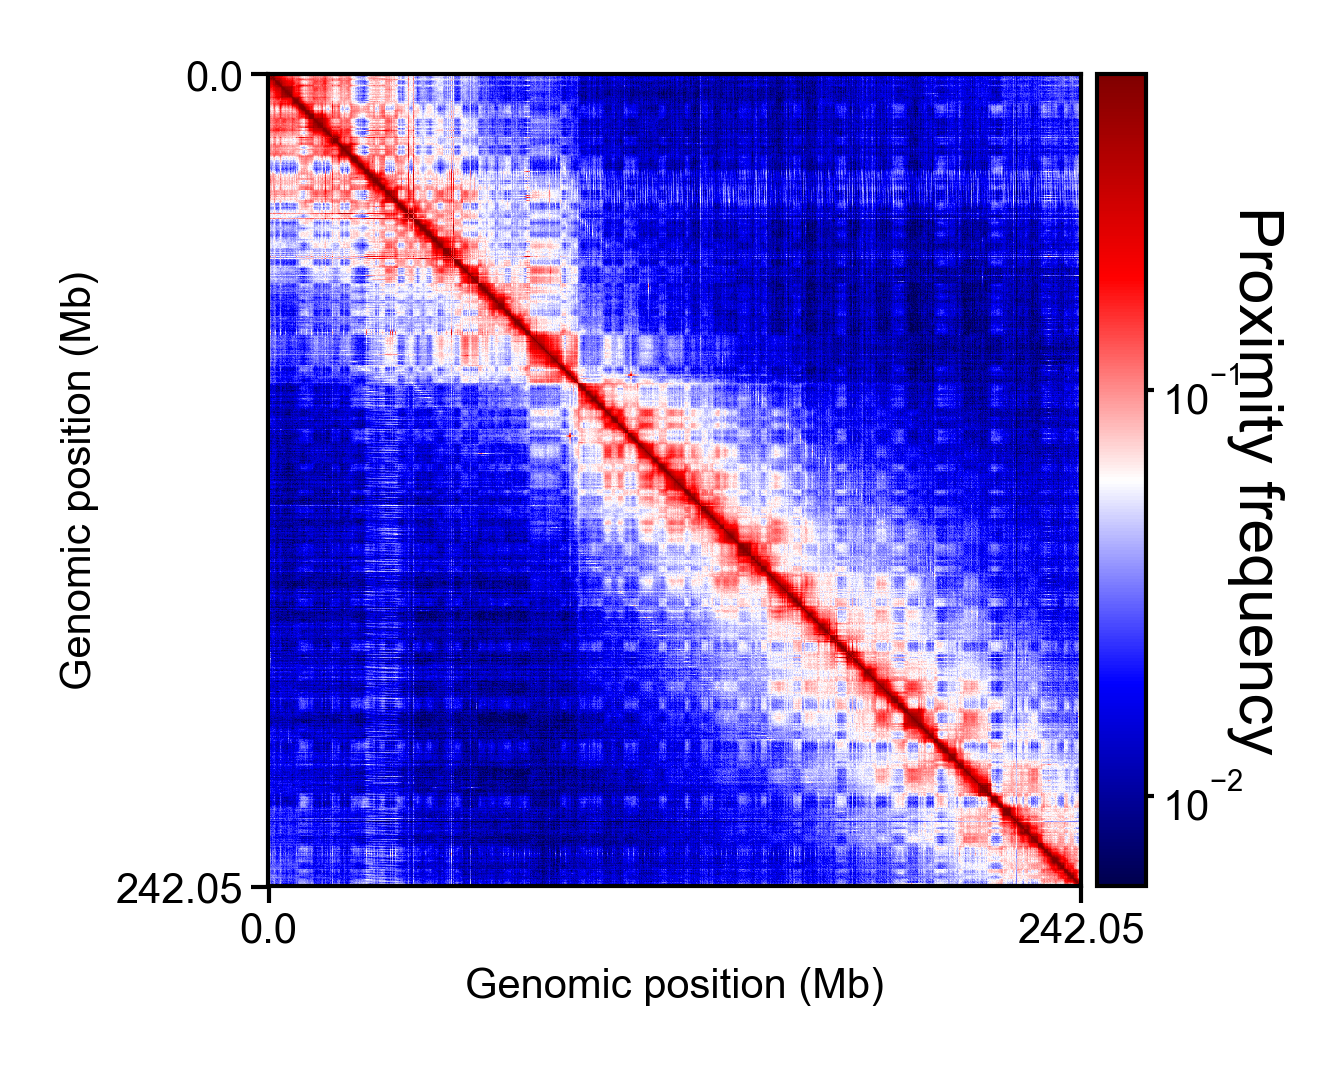

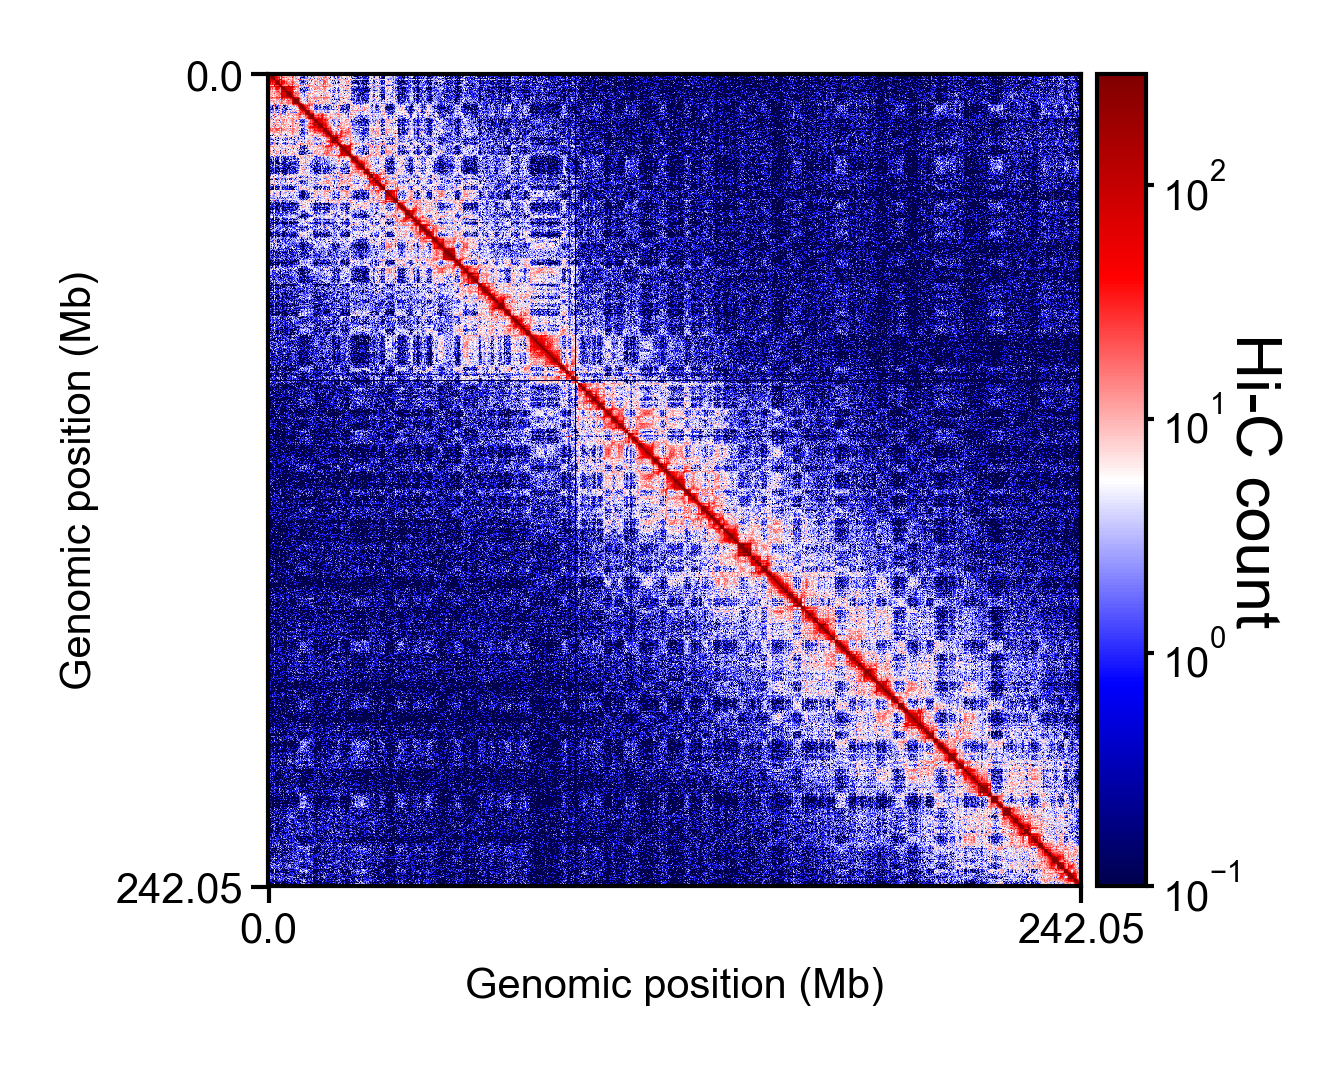

In [121]:
from source.figure_tools.distmap import plot_distance_map
print(figure_folder)
from matplotlib.colors import LogNorm

contact_limits = [0.006, 0.6]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = matplotlib.cm.get_cmap('seismic')
contact_cmap.set_bad(color=[0.,0.,0.,1])

contact_ax = plot_distance_map(contact_rep1_map, 
                               cmap=contact_cmap,
                               color_limits=contact_limits,
                               color_norm=contact_norm,
                               ticks=[0,len(contact_rep1_map)],
                               tick_labels=np.round([data_rep1['start_position_Mb'][0],
                                                     data_rep1['end_position_Mb'][-1],],2), 
                               ax_label='Genomic position (Mb)', 
                               colorbar_labels='Proximity frequency',
                               save=True, save_folder=figure_folder, 
                               save_basename=f'FigS2E1_chr2_proximity_freq_map_new.pdf',
                               font_size=5)


hic_limits = [0.1, 300]
hic_norm = LogNorm(vmin=np.min(hic_limits), 
                   vmax=np.max(hic_limits))
hic_cmap = matplotlib.cm.get_cmap('seismic')
hic_cmap.set_bad(color=[0.,0.,0.,1])

hic_ax = plot_distance_map(hic_map, 
                           cmap=hic_cmap,
                           color_limits=hic_limits,
                           color_norm=hic_norm,
                           ticks=[0,len(contact_rep1_map)],
                           tick_labels=np.round([data_rep1['start_position_Mb'][0],
                                                 data_rep1['end_position_Mb'][-1],],2),                           ax_label='Genomic position (Mb)', 
                           colorbar_labels='Hi-C count',
                           save=True, save_folder=figure_folder, 
                           save_basename=f'FigS2E2_chr2_Hi-C_map_new.pdf',
                           font_size=5)

<a id='2.4'></a>
## 2.4 call compartments

0. p and q arms are treated separately
1. remove genomic effect by log-log linear regression between contact/hic map with genomic distance map and normalize with it
2. calculate correlation map
3. do PCA, use PC1 as candidate AB calling
4. merge very small compartment fragments for calling robustness

(FigS2F, Fig2D)

<a id='2.4.1'></a>
### 2.4.1 calculate and plot PC1, p-arm

(FigS2F)

In [53]:
# Do PCA
from sklearn.decomposition import PCA
# parameters used for PCA compartment calling
contact_gaussian_sigma = 0.5
hic_gaussian_sigma = 0.5

LinregressResult(slope=-0.5264883435929191, intercept=-1.2556196915920557, rvalue=-0.8618549309741282, pvalue=0.0, stderr=0.0012290171082306046)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


LinregressResult(slope=-0.7228033386786183, intercept=3.3748169744754692, rvalue=-0.7250408584341537, pvalue=0.0, stderr=0.0030186725566035987)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


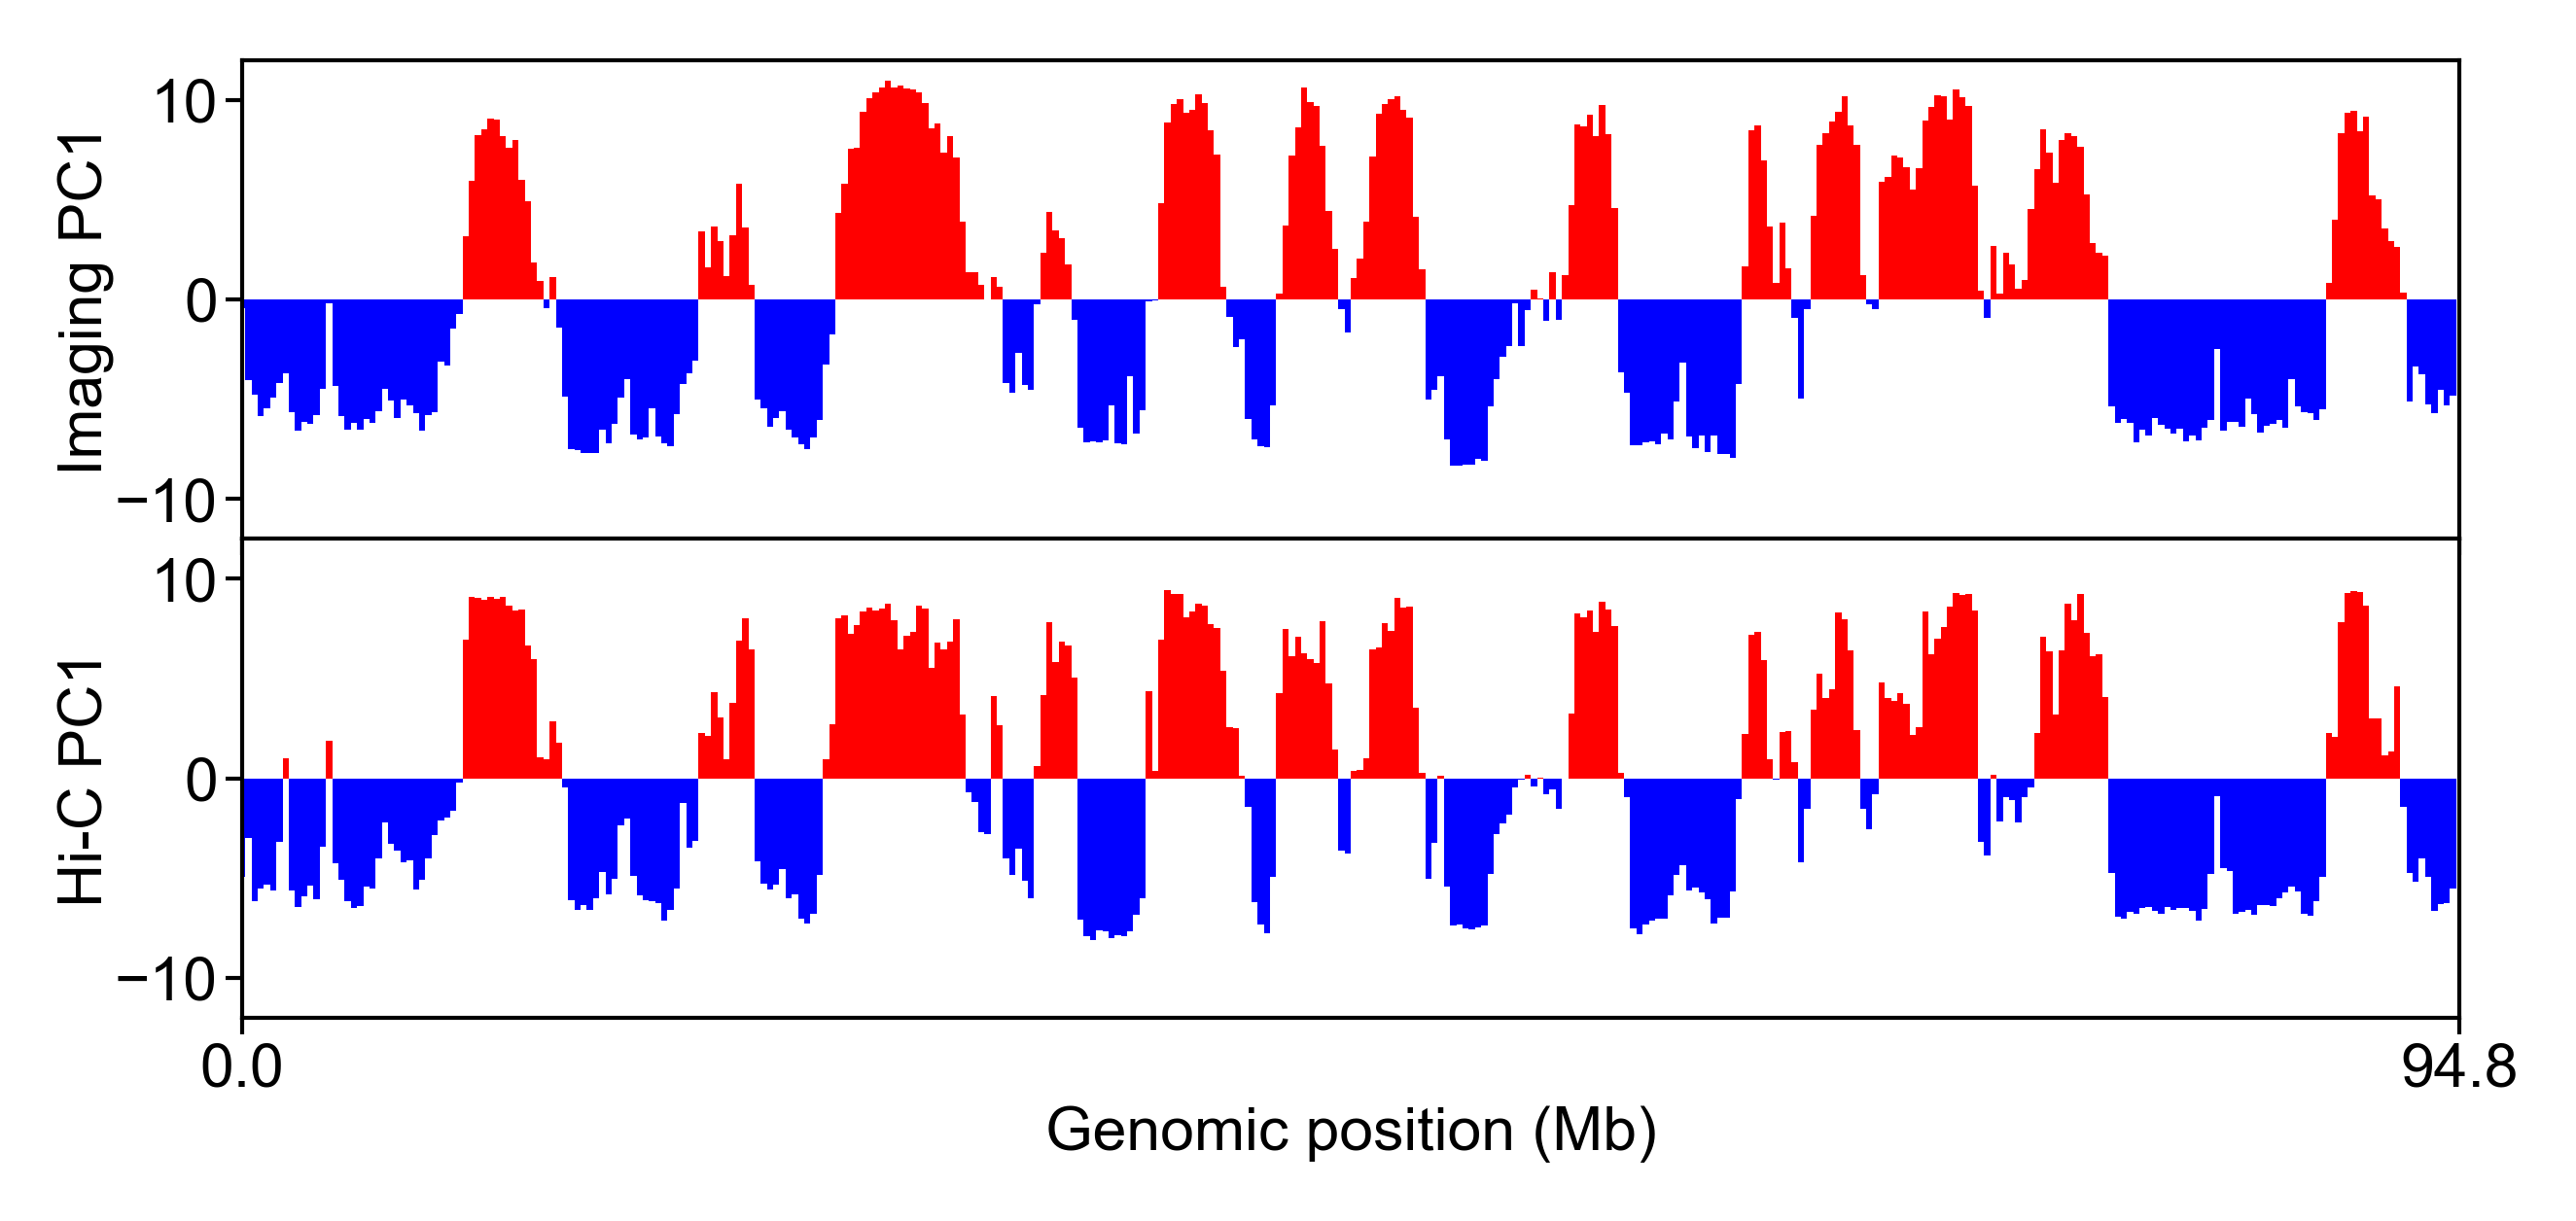

In [69]:
# normalize genomic distance effects
genomic_distance_map = squareform(pdist(data_rep1['mid_position_Mb'][:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

## p arm, proximity
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_contact_rep1_map = contact_rep1_map[p_crop, p_crop]
# normalize genomic distance effect
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
contact_entries = p_contact_rep1_map[np.triu_indices(len(p_contact_rep1_map),1)]
p_contact_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
p_contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_contact_kept]), 
                                      np.log(contact_entries[p_contact_kept]))
print(p_contact_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_contact_lr.slope + p_contact_lr.intercept)
for _i in range(len(p_normalization_mat)):
    p_normalization_mat[_i,_i] = 1
p_normed_contact_rep1_map = p_contact_rep1_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_contact_corr_rep1_map = np.corrcoef(gaussian_filter(p_normed_contact_rep1_map, contact_gaussian_sigma))
# PCA
p_contact_model_rep1 = PCA(1)
p_contact_model_rep1.fit(p_contact_corr_rep1_map)
p_contact_pc1_rep1 = np.reshape(p_contact_model_rep1.fit_transform(p_contact_corr_rep1_map), -1)

## p arm, Hi-C
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_hic_map = hic_map[p_crop, p_crop]
# normalize genomic distance effects
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
hic_entries = p_hic_map[np.triu_indices(len(p_hic_map),1)]
p_hic_kept = (genomic_distance_entries > 0) * (hic_entries > 0)
p_hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_hic_kept]), 
                              np.log(hic_entries[p_hic_kept]))
print(p_hic_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_hic_lr.slope + p_hic_lr.intercept)
#for _i in range(len(p_normalization_mat)):
#    p_normalization_mat[_i,_i] = 1
p_normed_hic_map = p_hic_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_hic_corr_map = np.corrcoef(gaussian_filter(p_normed_hic_map, hic_gaussian_sigma))
# PCA
p_hic_model = PCA(1)
p_hic_model.fit(p_hic_corr_map)
p_hic_pc1 = np.reshape(p_hic_model.fit_transform(p_hic_corr_map), -1)


# Plot vs. Hi-C
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(p_contact_pc1_rep1>=0)[0],
               p_contact_pc1_rep1[p_contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(p_contact_pc1_rep1<0)[0],
               p_contact_pc1_rep1[p_contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-12,12])
contact_ax.set_yticks([-10,0,10])
contact_ax.set_ylabel("Imaging PC1", fontsize=_font_size, labelpad=0)

# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(p_hic_pc1>=0)[0],
               p_hic_pc1[p_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(p_hic_pc1<0)[0],
               p_hic_pc1[p_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-12,12])
hic_ax.set_yticks([-10,0,10])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(p_contact_pc1_rep1)])
_xticks = [0, len(p_contact_pc1_rep1)]
_xticklabels =  [data_rep1['start_position_Mb'][p_crop.start],
                 data_rep1['end_position_Mb'][p_crop.stop-1],] 

hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(_xticklabels)

hic_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2F1_chr2_p_arm_PC1_barplot_rep1.pdf'), transparent=True)
plt.savefig(os.path.join(figure_folder, f'FigS2F1_chr2_p_arm_PC1_barplot_rep1.png'), transparent=True)

plt.show()

### q-arm

LinregressResult(slope=-0.6411315243663968, intercept=-1.0719082540079938, rvalue=-0.9191870623554915, pvalue=0.0, stderr=0.0006726793654640368)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


LinregressResult(slope=-0.7451356470768324, intercept=3.43582411307496, rvalue=-0.7769559406457006, pvalue=0.0, stderr=0.0018034121285637676)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


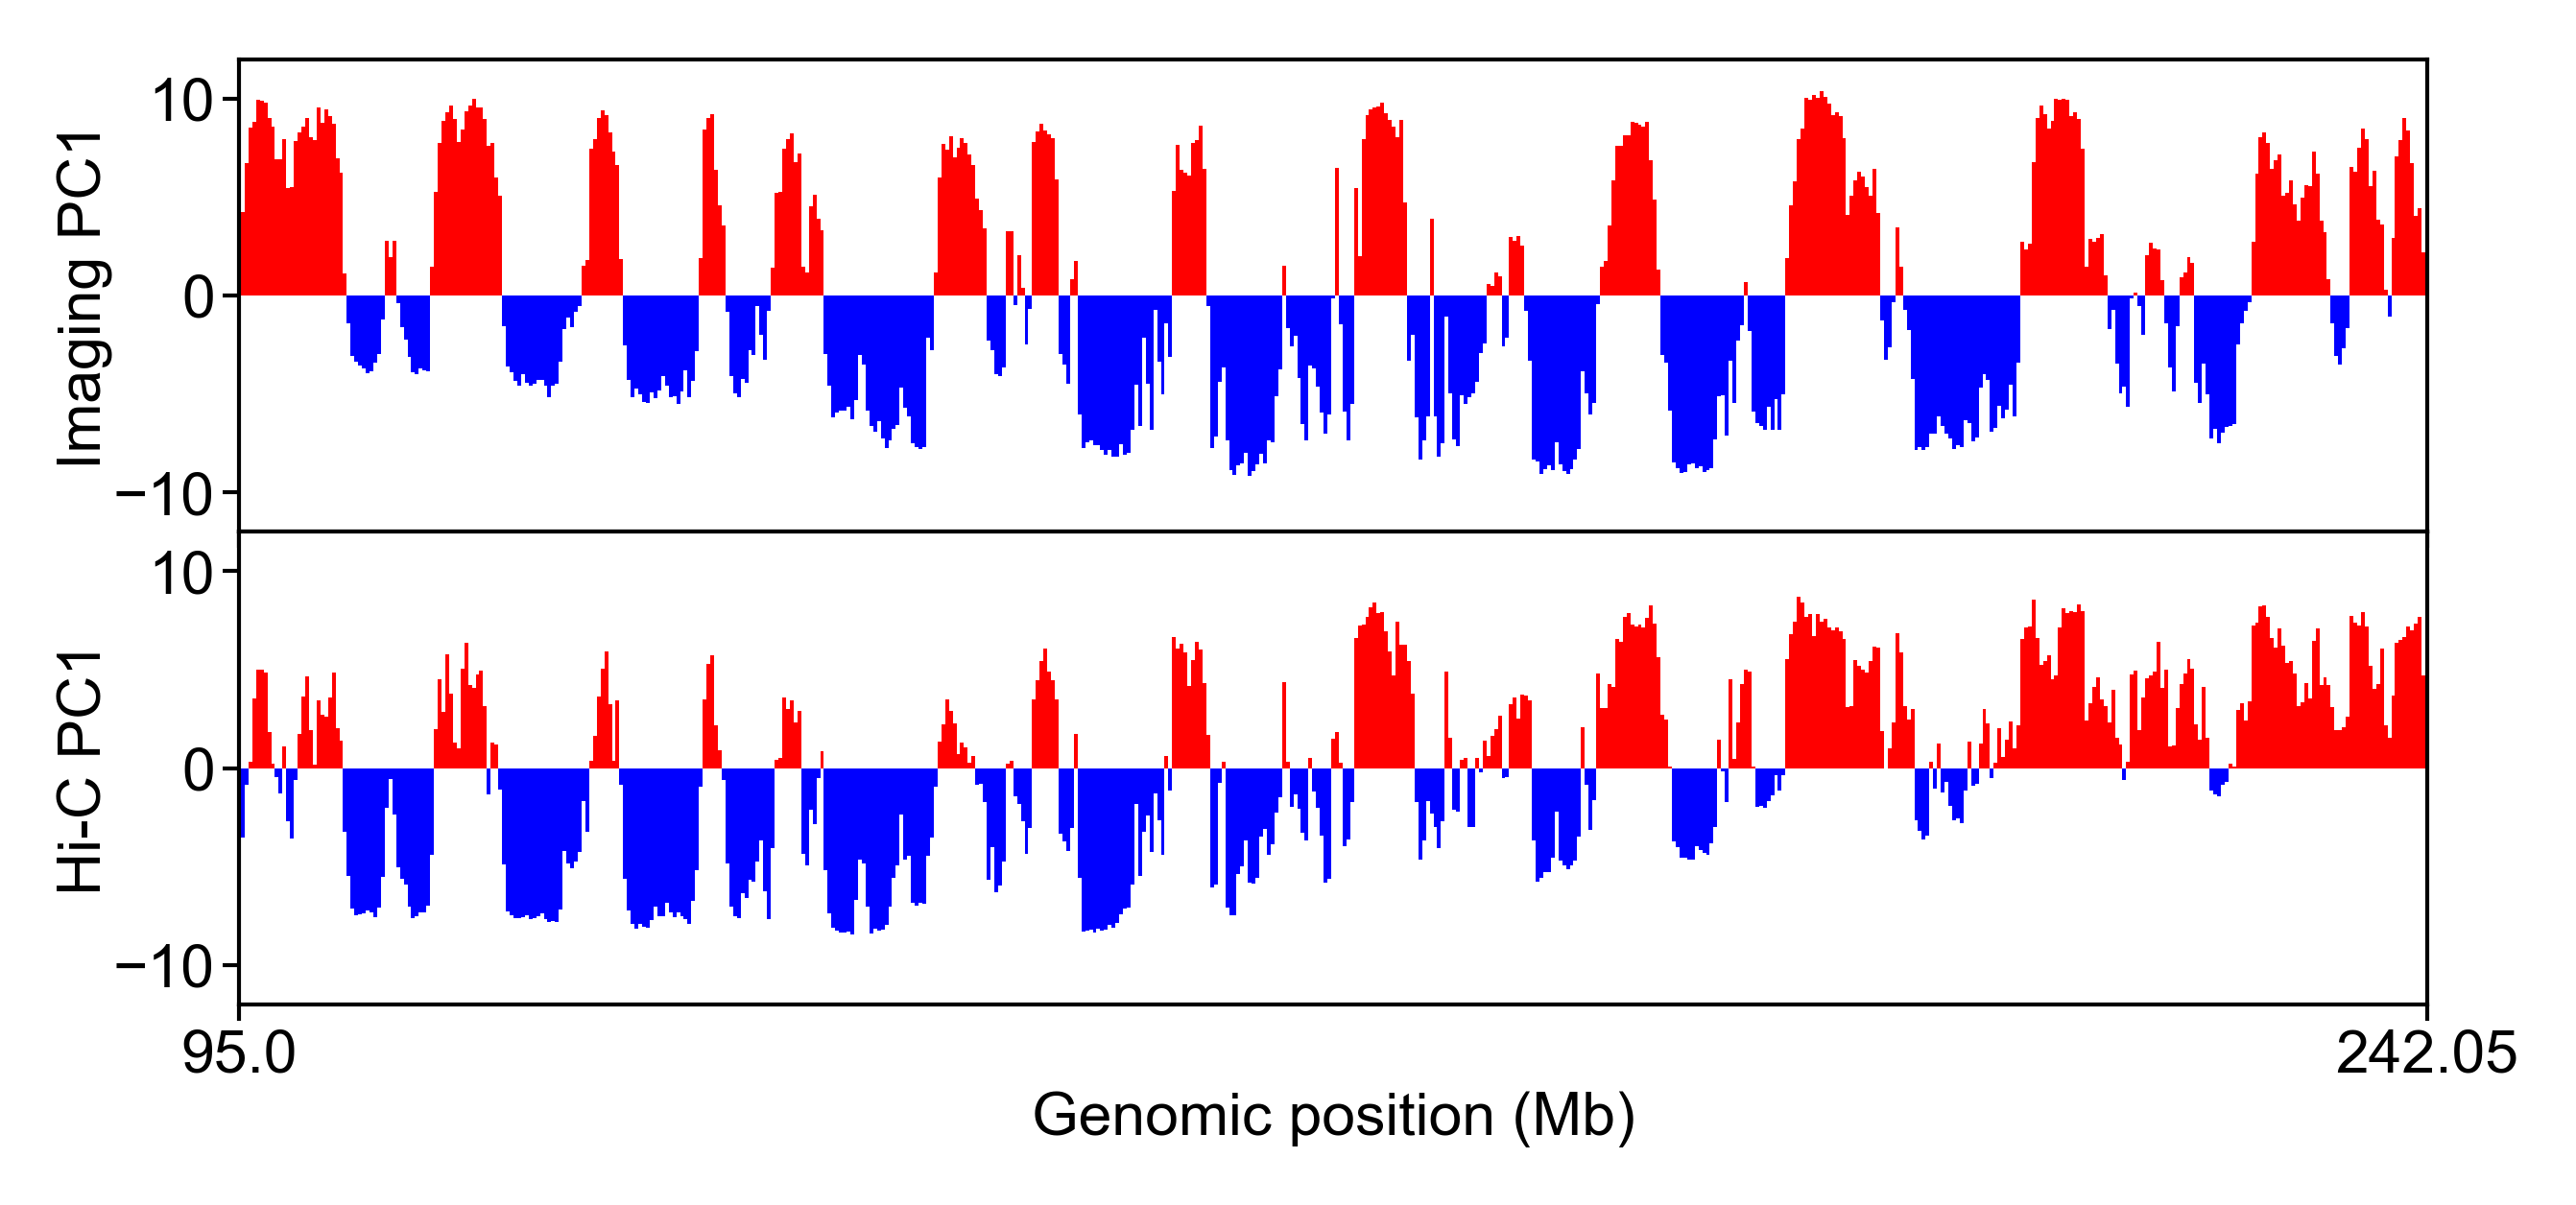

In [151]:
# normalize genomic distance effects
genomic_distance_map = squareform(pdist(data_rep1['mid_position_Mb'][:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

## p arm, proximity
q_gd_map = genomic_distance_map[q_crop, q_crop]
q_contact_rep1_map = contact_rep1_map[q_crop, q_crop]
# normalize genomic distance effect
genomic_distance_entries = q_gd_map[np.triu_indices(len(q_gd_map),1)]
contact_entries = q_contact_rep1_map[np.triu_indices(len(q_contact_rep1_map),1)]
q_contact_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
q_contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[q_contact_kept]), 
                                      np.log(contact_entries[q_contact_kept]))
print(q_contact_lr)
q_normalization_mat = np.exp(np.log(q_gd_map) * q_contact_lr.slope + q_contact_lr.intercept)
for _i in range(len(q_normalization_mat)):
    q_normalization_mat[_i,_i] = 1
q_normed_contact_rep1_map = q_contact_rep1_map / q_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

q_contact_corr_rep1_map = np.corrcoef(gaussian_filter(q_normed_contact_rep1_map, contact_gaussian_sigma))
# PCA
q_contact_model_rep1 = PCA(1)
q_contact_model_rep1.fit(q_contact_corr_rep1_map)
q_contact_pc1_rep1 = np.reshape(q_contact_model_rep1.fit_transform(q_contact_corr_rep1_map), -1)

## p arm, Hi-C
q_gd_map = genomic_distance_map[q_crop, q_crop]
q_hic_map = hic_map[q_crop, q_crop]
# normalize genomic distance effects
genomic_distance_entries = q_gd_map[np.triu_indices(len(q_gd_map),1)]
hic_entries = q_hic_map[np.triu_indices(len(q_hic_map),1)]
q_hic_kept = (genomic_distance_entries > 0) * (hic_entries > 0)
q_hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[q_hic_kept]), 
                              np.log(hic_entries[q_hic_kept]))
print(q_hic_lr)
q_normalization_mat = np.exp(np.log(q_gd_map) * q_hic_lr.slope + q_hic_lr.intercept)
#for _i in range(len(q_normalization_mat)):
#    q_normalization_mat[_i,_i] = 1
q_normed_hic_map = q_hic_map / q_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

q_hic_corr_map = np.corrcoef(gaussian_filter(q_normed_hic_map, hic_gaussian_sigma))
# PCA
q_hic_model = PCA(1)
q_hic_model.fit(q_hic_corr_map)
q_hic_pc1 = np.reshape(q_hic_model.fit_transform(q_hic_corr_map), -1)


# Plot vs. Hi-C
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(q_contact_pc1_rep1>=0)[0],
               q_contact_pc1_rep1[q_contact_pc1_rep1>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(q_contact_pc1_rep1<0)[0],
               q_contact_pc1_rep1[q_contact_pc1_rep1<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-12,12])
contact_ax.set_yticks([-10,0,10])
contact_ax.set_ylabel("Imaging PC1", fontsize=_font_size, labelpad=0)

# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(q_hic_pc1>=0)[0],
               q_hic_pc1[q_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(q_hic_pc1<0)[0],
               q_hic_pc1[q_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-12,12])
hic_ax.set_yticks([-10,0,10])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(q_contact_pc1_rep1)])
_xticks = [0, len(q_contact_pc1_rep1)]
_xticklabels =  [data_rep1['start_position_Mb'][q_crop.start],
                 data_rep1['end_position_Mb'][q_crop.stop-1],] 

hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(_xticklabels)

hic_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'FigS2F2_chr2_q_arm_PC1_barplot_rep1.pdf'), transparent=True)

plt.show()

<a id='2.4.2'></a>
### 2.4.2 further merge small domains and save compartments

Merge small compartments with, which is <=500kb in chr2 case

In [136]:
min_compartment_size = 3

temp_p_AB_dict = {'A': np.where(p_contact_pc1_rep1 >= 0)[0], 
                  'B': np.where(p_contact_pc1_rep1 < 0)[0], 
                  } 
temp_q_AB_dict = {'A': np.where(q_contact_pc1_rep1 >= 0)[0]+q_crop.start, 
                  'B': np.where(q_contact_pc1_rep1 < 0)[0]+q_crop.start, 
                  } 
temp_AB_dict = {'A':np.concatenate([temp_p_AB_dict['A'],temp_q_AB_dict['A']]),
                'B':np.concatenate([temp_p_AB_dict['B'],temp_q_AB_dict['B']]),}

temp_AB_vector = np.ones(len(zxys_rep1_list[0])).astype(np.int) * -1
temp_AB_vector[temp_AB_dict['A']] = 1
temp_AB_vector[temp_AB_dict['B']] = 0

num_small_compartment = np.inf
prev_v = temp_AB_vector[0]
while num_small_compartment > 0:
    # find indices for all sub-comaprtments
    all_comp_inds = []
    _comp_inds = []
    prev_v = temp_AB_vector[0] # initialize previous compartment
    for _i, _v in enumerate(temp_AB_vector):
        if prev_v != _v:
            all_comp_inds.append(_comp_inds)
            _comp_inds = [_i]
        else:
            _comp_inds.append(_i)            
        prev_v = _v
    if _comp_inds != []:
        all_comp_inds.append(_comp_inds)
    # calculate length of each compartment
    all_comp_lens = np.array([len(_c) for _c in all_comp_inds])
    # update number of small comparment
    num_small_compartment = np.sum(all_comp_lens < min_compartment_size)
    
    # choose the smallest compartment to flip its AB
    if num_small_compartment > 0:
        print(all_comp_lens, num_small_compartment)
        flip_ind = np.argmin(all_comp_lens)
        temp_AB_vector[np.array(all_comp_inds[flip_ind])] = 1 - temp_AB_vector[np.array(all_comp_inds[flip_ind])]
    
# based on this cleaned AB_vector, recreate AB_dict
data_rep1['AB_dict'] = {
    'A': np.where(temp_AB_vector==1)[0],
    'B': np.where(temp_AB_vector==0)[0],
}
data_rep1['p_AB_dict'] = {
    'A': np.where(temp_AB_vector[p_crop]==1)[0]+p_crop.start,
    'B': np.where(temp_AB_vector[p_crop]==0)[0]+p_crop.start,
}
data_rep1['q_AB_dict'] = {
    'A': np.where(temp_AB_vector[q_crop]==1)[0]+q_crop.start,
    'B': np.where(temp_AB_vector[q_crop]==0)[0]+q_crop.start,
}

[36 13  1  1 23  9 13 27  6  5 14 11  8 10  2 12 17  2  1  1  1  9 20  8
  3  9  2 17  1 19 35 13  8 29 10  3  9 19 21 11 20  7 12 14 29 14  5  2
  1  2  2  7  3  2 25  9 20  1 13  1  4 14  6  1 14  4  2  4 20 16 22  1
 10 25  4  2 31 23  7  1  2  5  4  4 15 21  5 10  1  9] 23
[36 15 23  9 13 27  6  5 14 11  8 10  2 12 17  2  1  1  1  9 20  8  3  9
  2 17  1 19 35 13  8 29 10  3  9 19 21 11 20  7 12 14 29 14  5  2  1  2
  2  7  3  2 25  9 20  1 13  1  4 14  6  1 14  4  2  4 20 16 22  1 10 25
  4  2 31 23  7  1  2  5  4  4 15 21  5 10  1  9] 21
[36 15 23  9 13 27  6  5 14 11  8 10  2 12 17  4  1  9 20  8  3  9  2 17
  1 19 35 13  8 29 10  3  9 19 21 11 20  7 12 14 29 14  5  2  1  2  2  7
  3  2 25  9 20  1 13  1  4 14  6  1 14  4  2  4 20 16 22  1 10 25  4  2
 31 23  7  1  2  5  4  4 15 21  5 10  1  9] 18
[36 15 23  9 13 27  6  5 14 11  8 10  2 12 17 14 20  8  3  9  2 17  1 19
 35 13  8 29 10  3  9 19 21 11 20  7 12 14 29 14  5  2  1  2  2  7  3  2
 25  9 20  1 13  1  4 14  6  1 14  4  

In [57]:
pickle.dump(data_rep1['AB_dict'], 
            open(os.path.join(data_folder, f'chr2_rep1_AB_dict_{contact_gaussian_sigma}.pkl'), 'wb'))

<a id='2.4.3'></a>
### 2.4.3 plot correlation map with AB calling

(Fig2D)

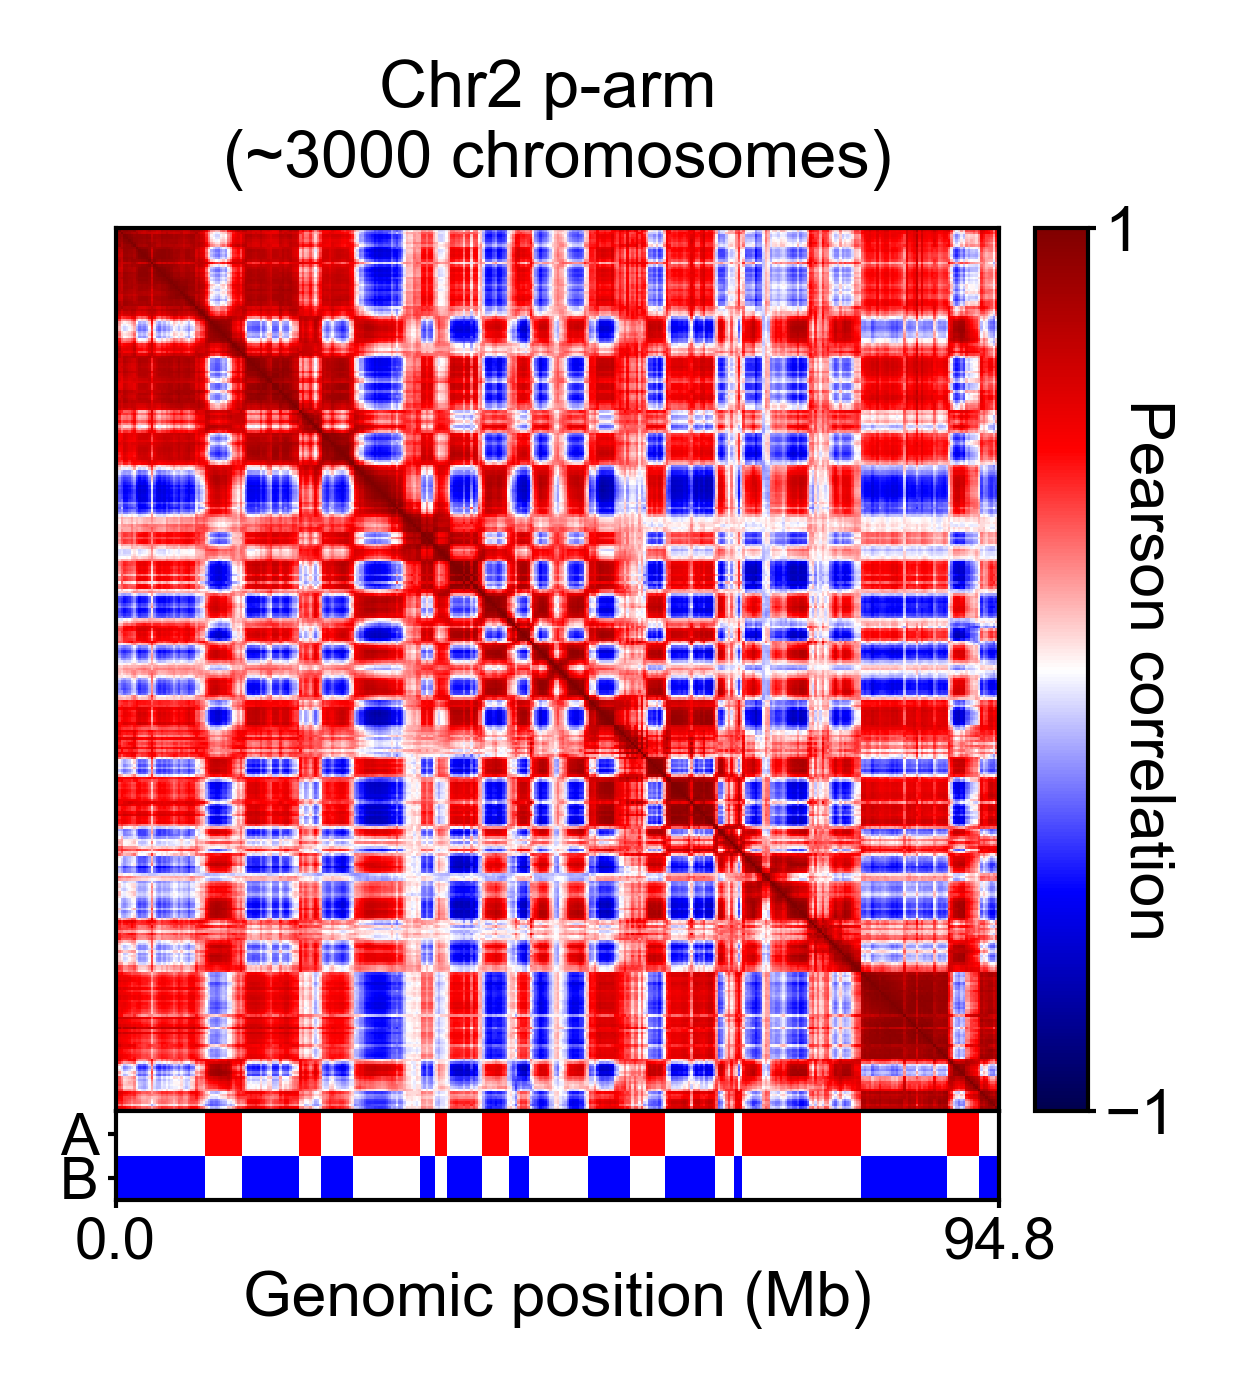

In [156]:
lims = [0,len(p_contact_corr_rep1_map)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(p_contact_corr_rep1_map, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['p_AB_dict']['A']-p_crop.start, height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['p_AB_dict']['B']-p_crop.start, height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])
bot_ax.set_yticks([0.5,-0.5])
bot_ax.set_yticklabels(["A","B"])

_xticks = [-0.5, len(p_contact_pc1_rep1)-0.5]
_xticklabels =  [data_rep1['start_position_Mb'][p_crop.start],
                 data_rep1['end_position_Mb'][p_crop.stop-1],] 

bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(_xticklabels)

# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=0)

# set limits
bot_ax.set_xlim(xlims-0.5)

ax1.set_title(f"Chr2 p-arm \n(~{np.round(len(data_rep1['chrom_ids']),-2)} chromosomes)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2D1_chr2_p_arm_contact_corr_rep1.pdf'), transparent=True)

plt.show()

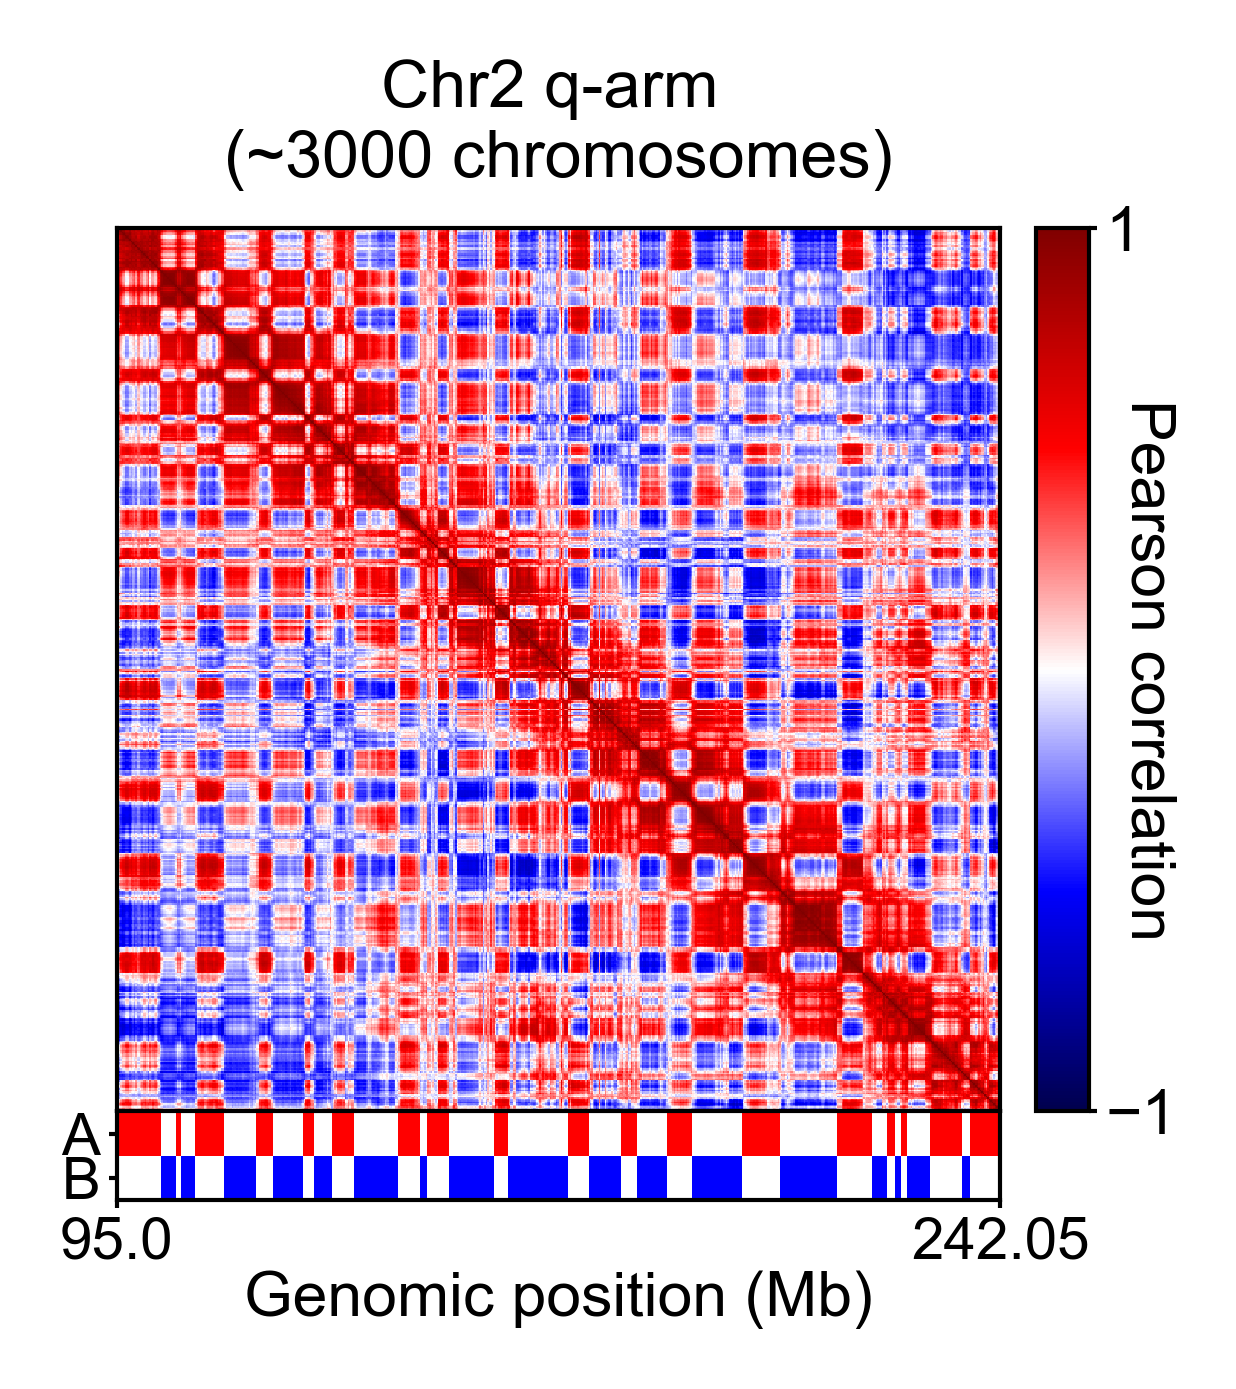

In [155]:
lims = [0,len(q_contact_corr_rep1_map)]

xlims = np.array([min(lims), max(lims)])
ylims = np.array([min(lims), max(lims)])

from mpl_toolkits.axes_grid1 import make_axes_locatable

domain_line_color = [1,1,0,1]
domain_line_width = 1.5
bad_color=[0,0,0,1]

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)

# create a color map
current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color=[0.5,0.5,0.5,1])

_pf = ax1.imshow(q_contact_corr_rep1_map, cmap=current_cmap, vmin=-1, vmax=1)

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1, ticks=[-1,1])
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Pearson correlation', 
               fontsize=_font_size, labelpad=0, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(data_rep1['q_AB_dict']['A']-q_crop.start, height=1, color='r', width=1, label='A')
bot_ax.bar(data_rep1['q_AB_dict']['B']-q_crop.start, height=-1, color='b', width=1, label='B')
bot_ax.set_yticks([])
bot_ax.set_yticklabels([])
bot_ax.set_ylim([-1,1])
bot_ax.set_yticks([0.5,-0.5])
bot_ax.set_yticklabels(["A","B"])

_xticks = [-0.5, len(q_contact_pc1_rep1)-0.5]
_xticklabels =  [data_rep1['start_position_Mb'][q_crop.start],
                 data_rep1['end_position_Mb'][q_crop.stop-1],] 

bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(_xticklabels)

# tick params
bot_ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]
# set labels
bot_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=0)

# set limits
bot_ax.set_xlim(xlims-0.5)

ax1.set_title(f"Chr2 q-arm \n(~{np.round(len(data_rep1['chrom_ids']),-2)} chromosomes)", fontsize=_font_size+0.5)

# save
plt.gcf().subplots_adjust(bottom=0.15, left=0.16, right=0.88)

plt.savefig(os.path.join(figure_folder, f'Fig2D2_chr2_q_arm_contact_corr_rep1.pdf'), transparent=True)

plt.show()

<a id='3'></a>
# 3. Analysis of A/B density in single-cells

<a id='3.1'></a>
## 3.1 calculate density scores

by placing gaussian pdf at the coordinates of genomic regions

In [66]:
# density for the entire chr
import multiprocessing as mp
num_threads=32
density_var = 125 # nm

_dna_density_args = [(_zxys,_zxys, data_rep1['AB_dict'], [density_var,density_var,density_var], True) 
                     for _zxys in data_rep1['dna_zxys']]
_dna_density_time = time.time()

print(f"Multiprocessing calculate dna_density_scores", end=' ')
if 'dna_density_scores' not in data_rep1:
    with mp.Pool(num_threads) as dna_density_pool:
        dna_density_dicts = dna_density_pool.starmap(ia.compartment_tools.scoring.spot_density_scores, _dna_density_args)
        dna_density_pool.close()
        dna_density_pool.join()
        dna_density_pool.terminate()
    # save
    data_rep1['dna_density_scores'] = dna_density_dicts
print(f"in {time.time()-_dna_density_time:.3f}s.")

Multiprocessing calculate dna_density_scores in 31.461s.


<a id='3.2'></a>
## 3.2 median density for chr2

medians are taken across chromosome copies

(FigS2G)

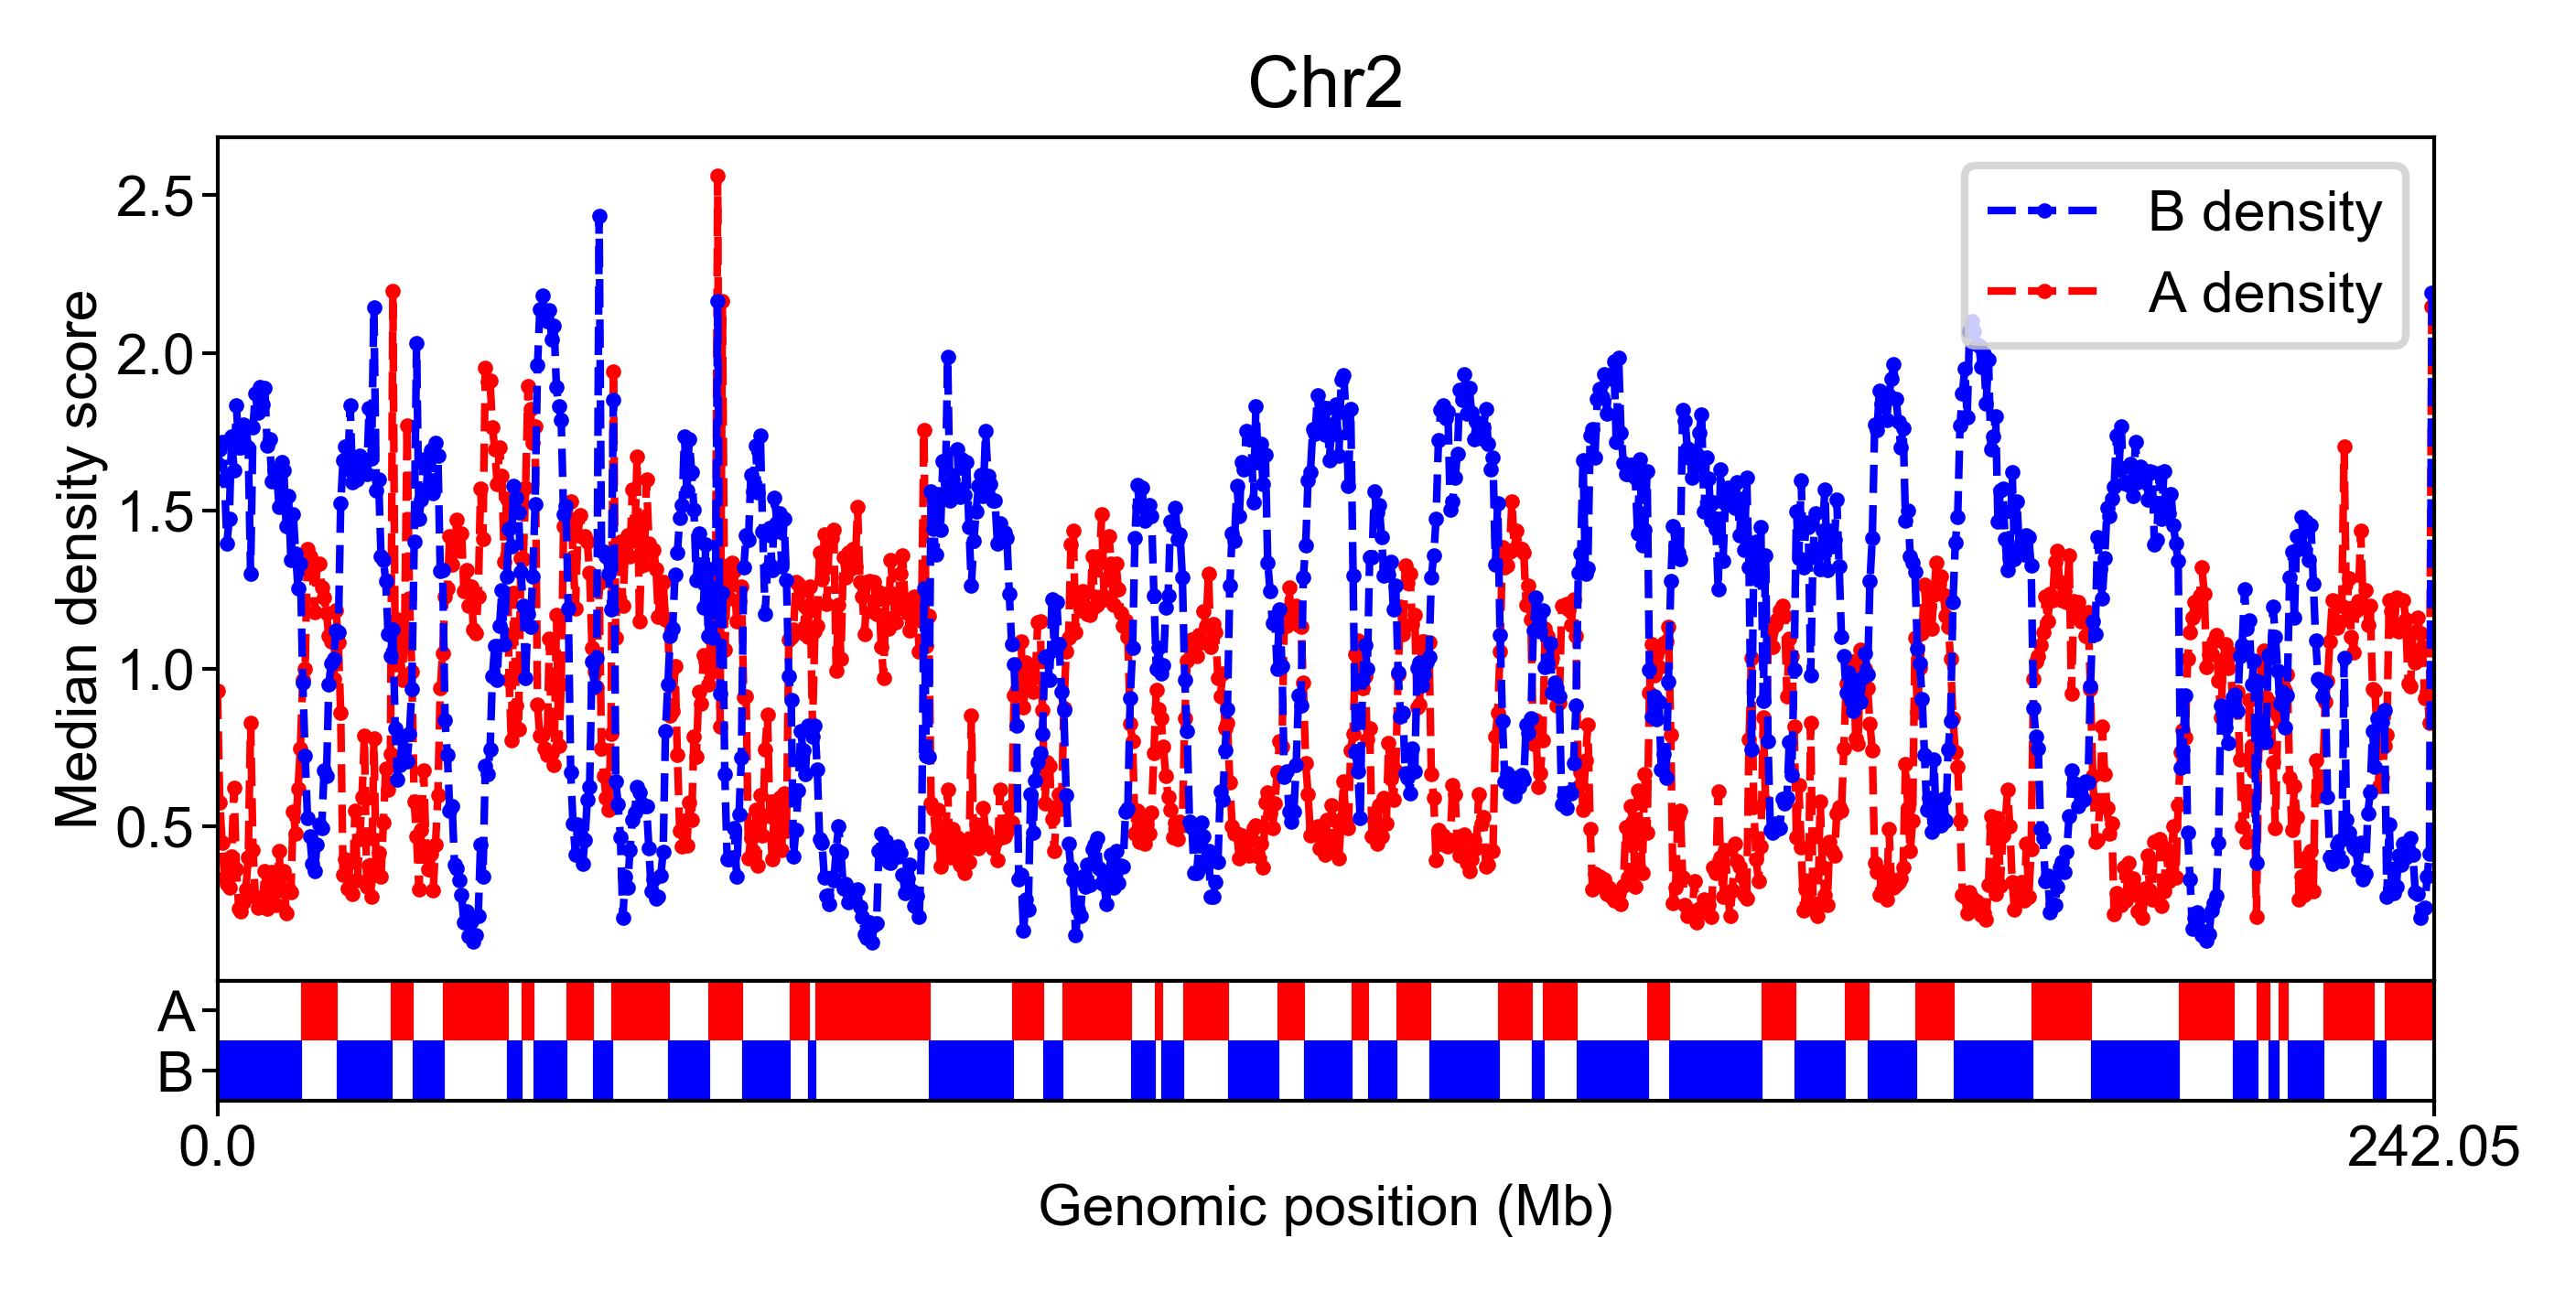

In [157]:
# Calculate median A, B density
median_A_scores = np.nanmedian([_s['A'] for _s in data_rep1['dna_density_scores']], axis=0)
median_B_scores = np.nanmedian([_s['B'] for _s in data_rep1['dna_density_scores']], axis=0)

# Plot
fig = plt.figure(figsize=(_double_col_width, _single_col_width),dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[7,1], hspace=0., wspace=0.2)

main_ax = plt.subplot(grid[0], xticklabels=[])

main_ax.plot(median_A_scores, 'r.--', label='A density', markersize=2, linewidth=1)
main_ax.plot(median_B_scores, 'b.--', label='B density', markersize=2, linewidth=1)

# ticks
main_ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=False) # remove bottom ticklabels for ax1
main_ax.tick_params('x', length=0)
[i[1].set_linewidth(_ticklabel_width) for i in main_ax.spines.items()]
main_ax.set_ylabel(f"Median density score", fontsize=_font_size, labelpad=1)

handles, labels = main_ax.get_legend_handles_labels()
main_ax.legend(handles[::-1], labels[::-1], fontsize=_font_size, loc='upper right')
main_ax.set_xlim(0,len(median_A_scores))
main_ax.set_title('Chr2', fontsize=_font_size+2, pad=4)


comp_ax = plt.subplot(grid[1], xticklabels=[], sharex=main_ax)
comp_ax.eventplot([data_rep1['AB_dict']['A'], data_rep1['AB_dict']['B']], lineoffsets=[0.5,-0.5],linelengths=1, linewidths=0.5,
                   colors=np.array([[1, 0, 0],[0, 0, 1]]))
#comp_ax.imshow(comp_vector[np.newaxis,:], cmap='seismic', vmin=-1, vmax=1)
comp_ax.tick_params('both', labelsize=_font_size, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in comp_ax.spines.items()]

comp_ax.set_yticks([0.5,-0.5])
comp_ax.set_yticklabels(["A","B"])
comp_ax.set_ylim([-1,1])
# ticks
_xticks = [0, len(median_A_scores)]
_xticklabels =  [data_rep1['start_position_Mb'][0],
                 data_rep1['end_position_Mb'][-1],] 

comp_ax.set_xticks(_xticks)
comp_ax.set_xticklabels(_xticklabels)

comp_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.1, left=0.05)

plt.savefig(os.path.join(figure_folder, 'FigS2G_chr2_median_AB_density_rep1.pdf'), transparent=True)

plt.show()

<a id='3.3'></a>
## 3.3 visualize single chromosome distance matrix with AB calling

(Fig3D)

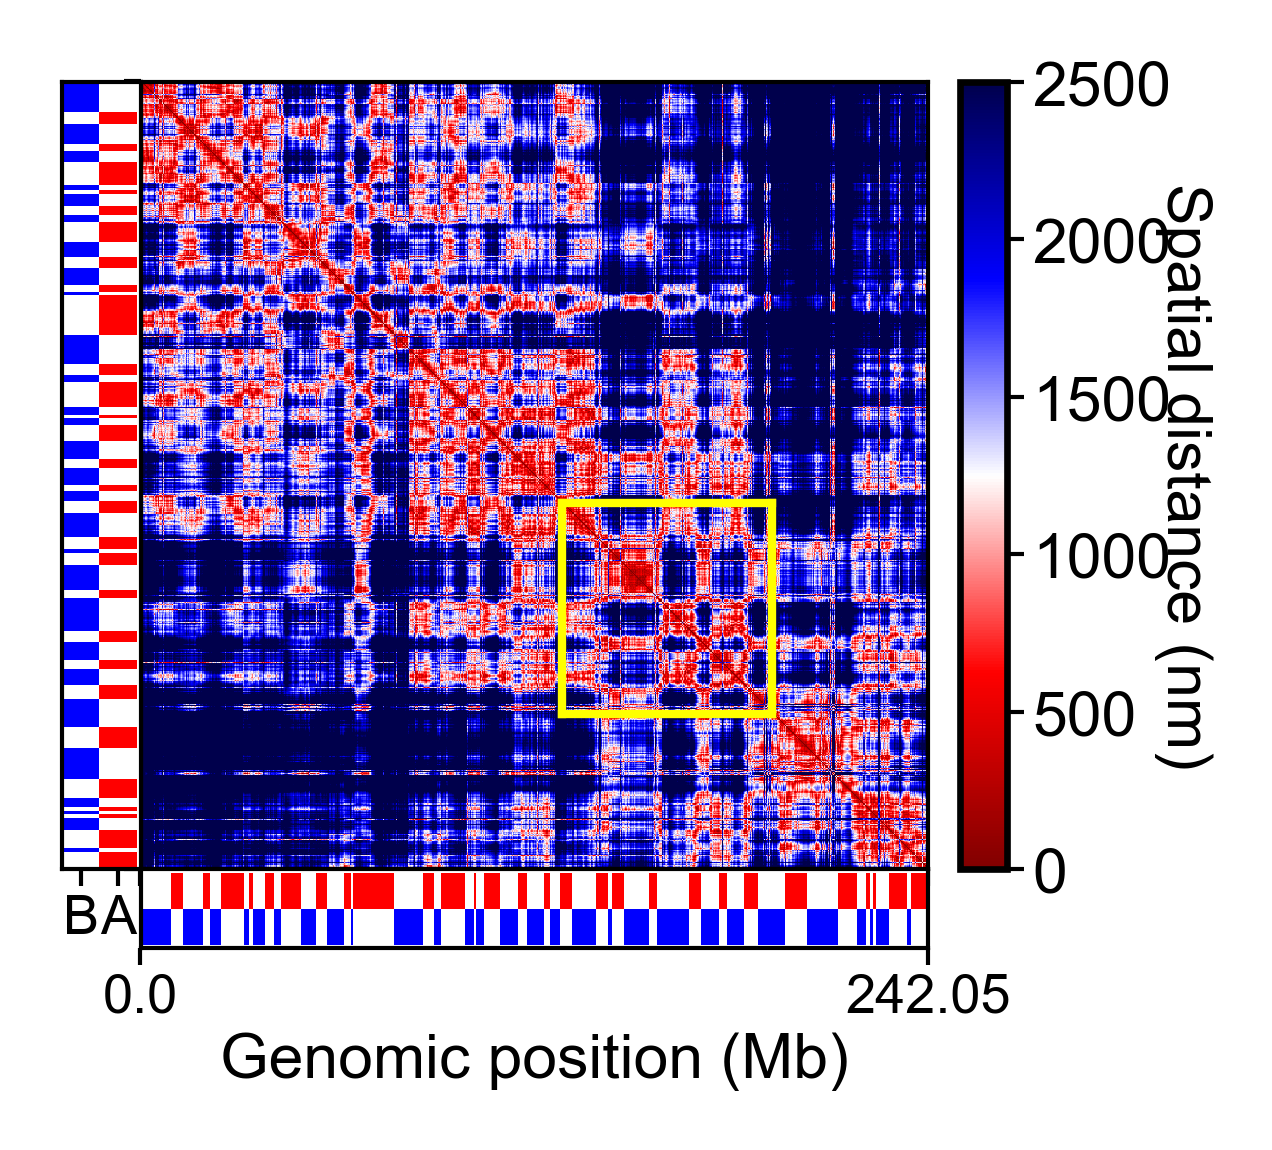

In [209]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

example_id = 0
_distmap = squareform(pdist(data_rep1['dna_zxys'][example_id]))

plot_limits = [0, 2500]
region_limits = [0, len(_distmap)]

example_cmap = matplotlib.cm.get_cmap('seismic_r')
example_cmap.set_bad(color=[0.,0.,0.,1])


fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)


_pf = ax1.imshow(_distmap, vmin=min(plot_limits), vmax=max(plot_limits),
                cmap=example_cmap)

ax1.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)
# create colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in cax.spines.items()]
cb = plt.colorbar(_pf, cax=cax, ax=ax1)
cb.set_label("Spatial distance (nm)", fontsize=_font_size, labelpad=5, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", sharex=ax1)
bot_ax.bar(data_rep1['AB_dict']['A'], np.ones(len(data_rep1['AB_dict']["A"])), color='r', width=1, label='A')
bot_ax.bar(data_rep1['AB_dict']['B'], -np.ones(len(data_rep1['AB_dict']["B"])), color='b', width=1, label='B')
bot_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
bot_ax.tick_params('y', labelsize=_font_size-1, 
                width=0, length=0,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1

[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]

# set labels
bot_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

# create left ax
left_ax = divider.append_axes('left', size='10%', pad="0%", sharey=ax1, xticks=[])
left_ax.barh(data_rep1['AB_dict']['A'], height=1, color='r', width=1, label='A')
left_ax.barh(data_rep1['AB_dict']['B'], height=1, left=-1, color='b', width=1, label='B')
left_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=False) # remove bottom ticklabels for ax1
left_ax.tick_params('y', labelsize=_font_size-1, 
                width=0, length=0,
                pad=1, labelbottom=True, labelleft=False) # remove bottom ticklabels for ax1

[i[1].set_linewidth(_ticklabel_width) for i in left_ax.spines.items()]
left_ax.set_xticks([-0.5, 0.5])
left_ax.set_xticklabels(['B', 'A'])
# set labels
#left_ax.set_ylabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

# set shared ticks
_min_tick_dists = int(min([max(xlims)-min(xlims), max(ylims)-min(ylims)]) / 5)
_xticks = [min(region_limits)-0.5, max(region_limits)]
_xticklabels = [data_rep1['start_position_Mb'][min(region_limits)], 
                data_rep1['end_position_Mb'][max(region_limits)-1]]
# set ticks
left_ax.set_yticks(_xticks)
left_ax.set_yticklabels(_xticklabels)
# set ticks
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(_xticklabels)
# set shared axes
ax1.set_xlim([min(region_limits), max(region_limits)])
ax1.set_ylim([max(region_limits), min(region_limits)])

# extra draw a yellow box
box_limits = [500, 750]
box_linewidth = 1
box_color = [1,1,0]
_start, _end = min(box_limits), max(box_limits)

ax1.plot(np.arange(_start, _end+1), _start*np.ones(
    _end+1-_start), color=box_color, linewidth=box_linewidth)
ax1.plot(_start*np.ones(_end+1-_start),
        np.arange(_start, _end+1), color=box_color, linewidth=box_linewidth)
ax1.plot(np.arange(_start, _end+1), _end*np.ones(
    _end+1-_start), color=box_color, linewidth=box_linewidth)
ax1.plot(_end*np.ones(_end+1-_start),
        np.arange(_start, _end+1), color=box_color, linewidth=box_linewidth)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3D1_chr2_example_distmap_chr-{example_id}_region-{region_limits}.pdf'), transparent=True)

plt.show()

### zoomed in example

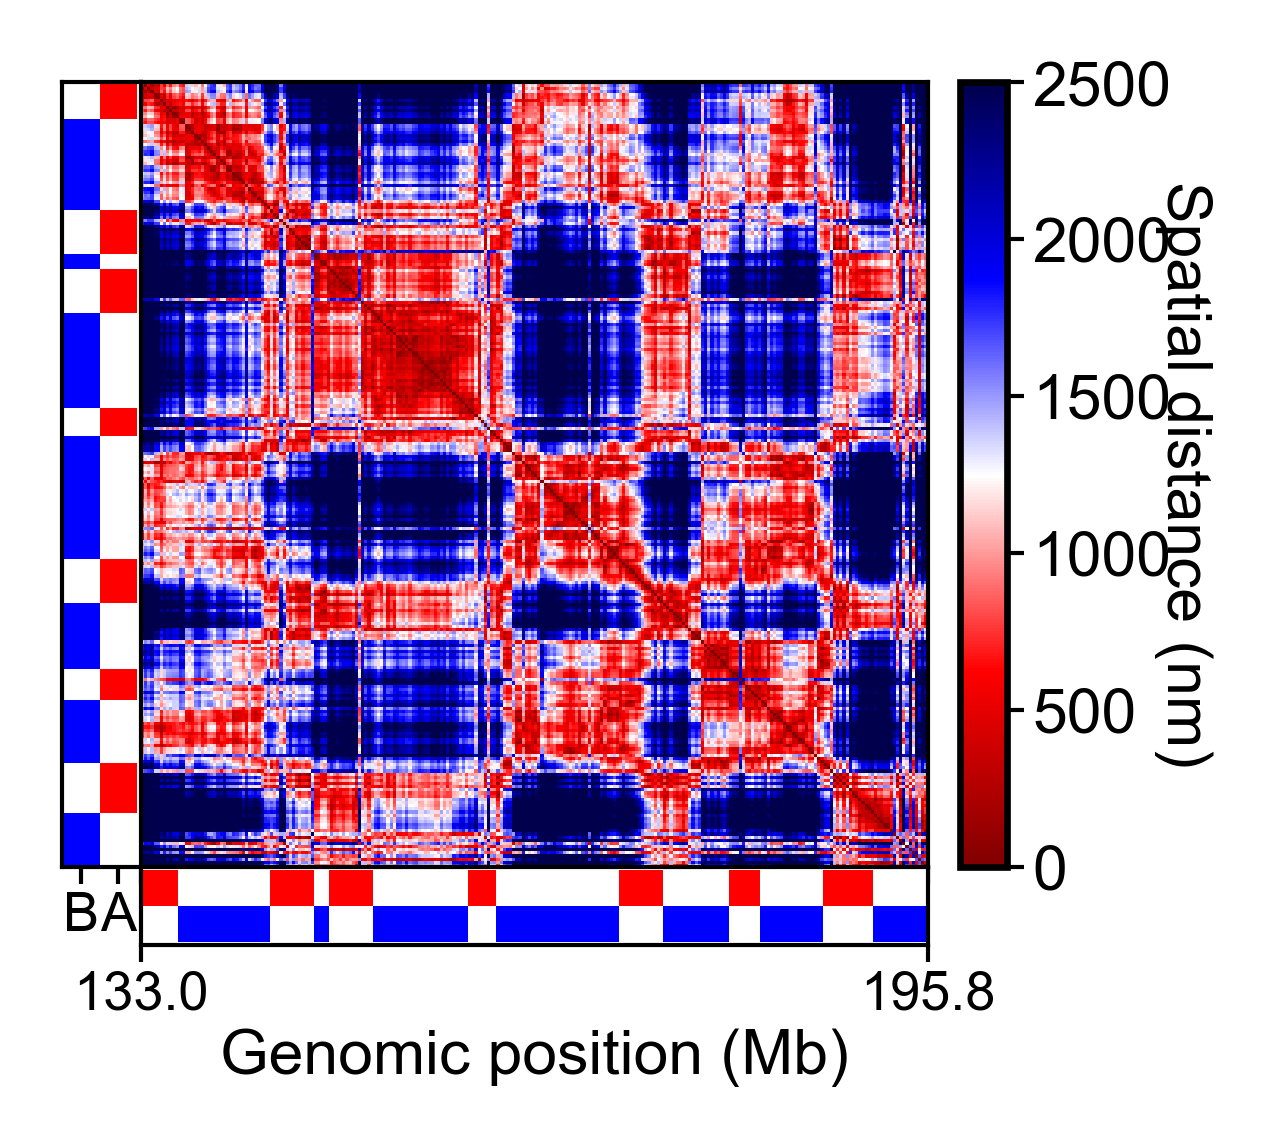

In [203]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_limits = [0, 2500]
region_limits = [500,750]

example_cmap = matplotlib.cm.get_cmap('seismic_r')
example_cmap.set_bad(color=[0.,0.,0.,1])


fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=600)


_pf = ax1.imshow(_distmap, vmin=min(plot_limits), vmax=max(plot_limits),
                cmap=example_cmap)

ax1.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]


# locate ax1
divider = make_axes_locatable(ax1)
# create colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in cax.spines.items()]
cb = plt.colorbar(_pf, cax=cax, ax=ax1)
cb.set_label("Spatial distance (nm)", fontsize=_font_size, labelpad=5, rotation=270)

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", sharex=ax1)
bot_ax.bar(data_rep1['AB_dict']['A'], np.ones(len(data_rep1['AB_dict']["A"])), color='r', width=1, label='A')
bot_ax.bar(data_rep1['AB_dict']['B'], -np.ones(len(data_rep1['AB_dict']["B"])), color='b', width=1, label='B')
bot_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
bot_ax.tick_params('y', labelsize=_font_size-1, 
                width=0, length=0,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1

[i[1].set_linewidth(_ticklabel_width) for i in bot_ax.spines.items()]

# set labels
bot_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

# create left ax
left_ax = divider.append_axes('left', size='10%', pad="0%", sharey=ax1, xticks=[])
left_ax.barh(data_rep1['AB_dict']['A'], height=1, color='r', width=1, label='A')
left_ax.barh(data_rep1['AB_dict']['B'], height=1, left=-1, color='b', width=1, label='B')
left_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=False) # remove bottom ticklabels for ax1
left_ax.tick_params('y', labelsize=_font_size-1, 
                width=0, length=0,
                pad=1, labelbottom=True, labelleft=False) # remove bottom ticklabels for ax1

[i[1].set_linewidth(_ticklabel_width) for i in left_ax.spines.items()]
left_ax.set_xticks([-0.5, 0.5])
left_ax.set_xticklabels(['B', 'A'])

# set shared ticks
_min_tick_dists = int(min([max(xlims)-min(xlims), max(ylims)-min(ylims)]) / 5)
_xticks = [min(region_limits)-0.5, max(region_limits)]
_xticklabels = [data_rep1['start_position_Mb'][min(region_limits)], 
                data_rep1['end_position_Mb'][max(region_limits)-1]]
# set ticks
left_ax.set_yticks(_xticks)
left_ax.set_yticklabels(_xticklabels)
# set ticks
bot_ax.set_xticks(_xticks)
bot_ax.set_xticklabels(_xticklabels)
# set shared axes
ax1.set_xlim([min(region_limits)-0.5, max(region_limits)])
ax1.set_ylim([max(region_limits)-0.5, min(region_limits)])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3D2_chr2_example_distmap_chr-{example_id}_region-{region_limits}.pdf'), transparent=True)

plt.show()

<a id='3.4'></a>
## 3.4 visualize density in the example chromosome 


0
-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x0000024B83CA8F60>
-- save 3d-rendering into file:\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\check_reproducibility\Chr2_figures\3d_render_chr2_chr-0_rep1_AB-calling.pdf


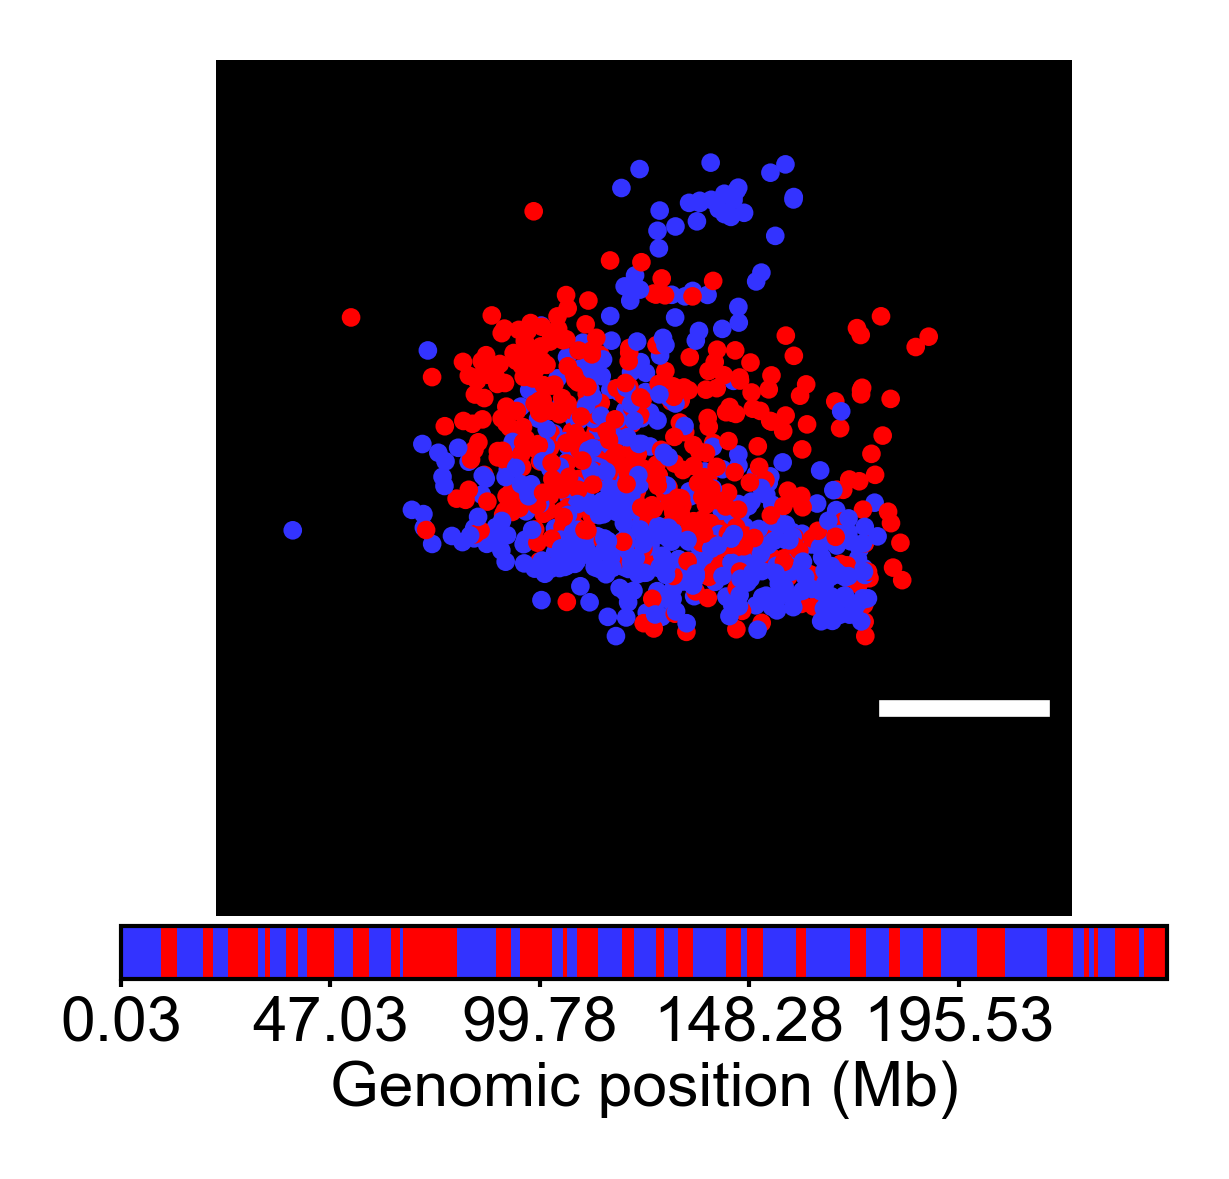

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x000002561D706320>
-- save 3d-rendering into file:\\10.245.74.158\Chromatin_NAS_4\Chromatin_Share\check_reproducibility\Chr2_figures\3d_render_chr2_chr-0_rep1_AB-ratio.pdf


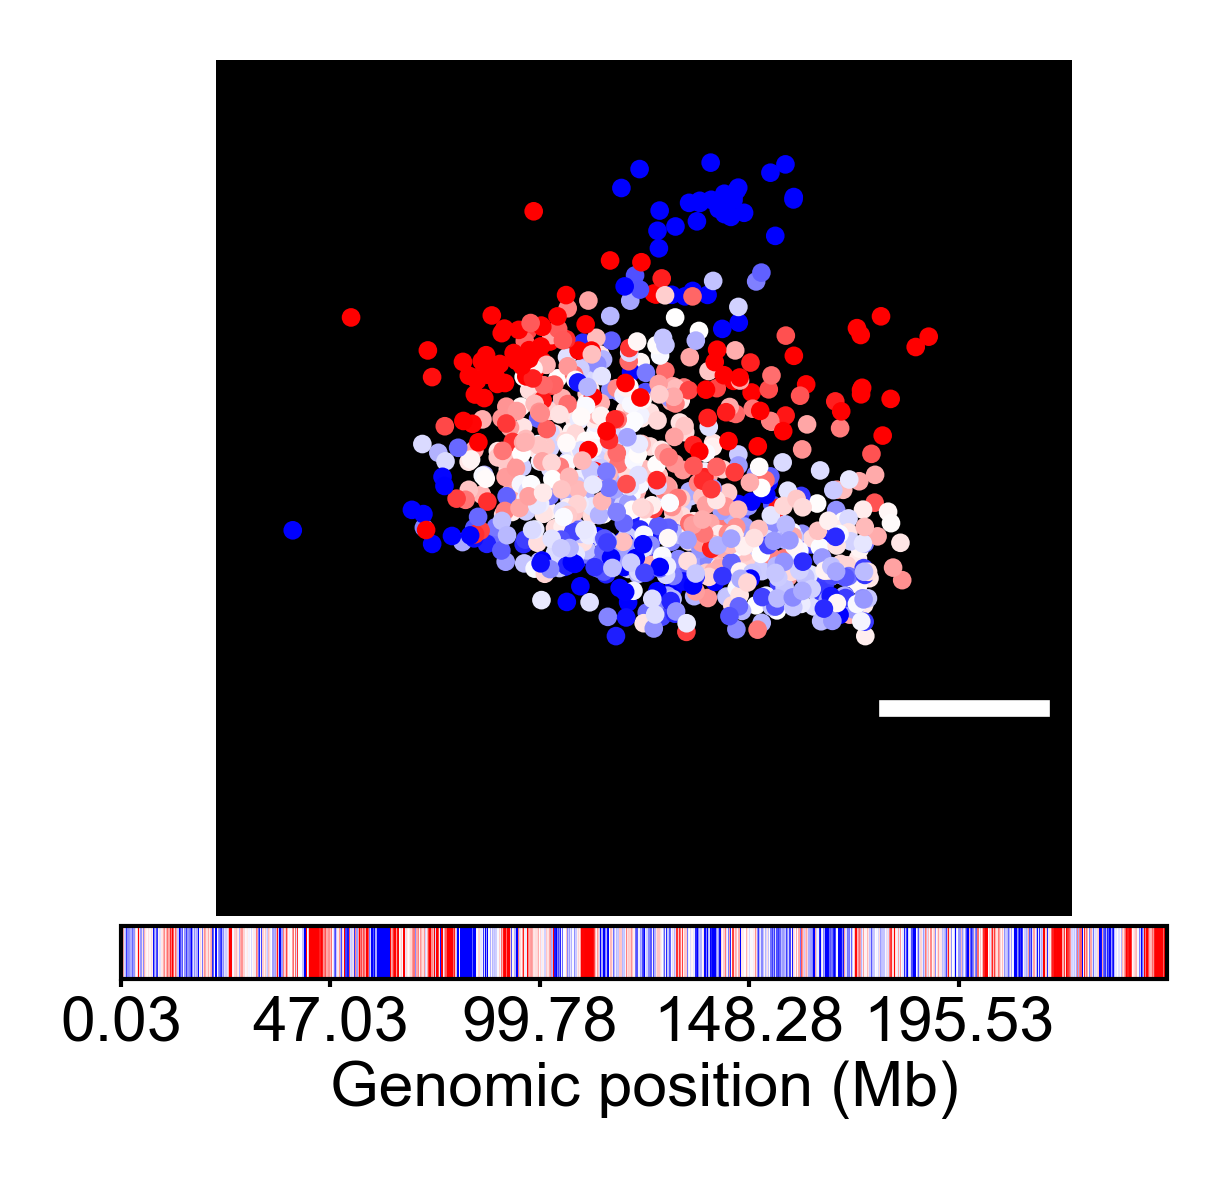

In [207]:
## prepare examples

# example chromosome id
example_id = 0
#for example_id in np.arange(1037,1057):
dna_zxys = data_rep1['dna_zxys'][example_id]
print(example_id)

# prepare AB score and log(A/B) ratio
ascores = data_rep1['dna_density_scores'][example_id]['A']
bscores = data_rep1['dna_density_scores'][example_id]['B']
abratios = np.log(ascores / bscores) - np.log(len(data_rep1['AB_dict']['A'])/len(data_rep1['AB_dict']['B']))
abratios = abratios / np.log(2)
def normalize_color(mat, vmin=None, vmax=None):
    _mat = np.array(mat).copy()
    if vmin is None:
        vmin = np.nanmin(_mat)
    if vmax is None:
        vmax = np.nanmax(_mat)
    # based on vmin vmax, do thresholding
    _mat[_mat < vmin] = vmin
    _mat[_mat > vmax] = vmax
    _mat = (_mat - np.nanmin(_mat)) / (np.nanmax(_mat) - np.nanmin(_mat))
    return _mat

## prepare colors
# compartment color cmap
comp_colors = []
for _i in np.arange(len(dna_zxys)):
    if _i in data_rep1['AB_dict']['A']:
        comp_colors.append([1,0,0,1])
    elif _i in data_rep1['AB_dict']['B']:
        comp_colors.append([0.2,0.2,1,1])
    else:
        raise ValueError
from matplotlib.colors import ListedColormap
comp_cmap = ListedColormap(comp_colors)

# ratio color map
ratio_cmap = matplotlib.cm.get_cmap('bwr')
color_limits = [-7.5, 7.5]
ratio_colors = np.array([np.array(ratio_cmap(_s)) 
                         for _s in normalize_color(abratios, 
                                                   vmin=min(color_limits),
                                                   vmax=max(color_limits))])
# plot AB calling
from source.figure_tools.image import chromosome_structure_3d_rendering
ax3d, cb = chromosome_structure_3d_rendering(dna_zxys, 
                                             cmap=comp_cmap, 
                                             image_radius=500,
                                             pca_align=False,
                                             marker_size=5, line_width=0.,
                                             marker_alpha=1, line_alpha=1,
                                             #view_azim_angle=180, view_elev_angle=90,
                                             cbar_tick_labels=data_rep1['mid_position_Mb'],
                                             cbar_label='Genomic position (Mb)',
                                             cbar_shrink=1,
                                             save=True, save_folder=figure_folder, 
                                             save_basename=f'3d_render_chr2_chr-{example_id}_rep1_AB-calling.pdf')
plt.show()

# plot ratio
ax3d, cb = chromosome_structure_3d_rendering(dna_zxys, 
                                             cmap=ratio_colors, 
                                             image_radius=500,
                                             pca_align=False,
                                             marker_size=5, line_width=0.,
                                             marker_alpha=1, line_alpha=1,
                                             #view_azim_angle=180, view_elev_angle=90,
                                             cbar_tick_labels=data_rep1['mid_position_Mb'],
                                             cbar_label='Genomic position (Mb)',
                                             cbar_shrink=1,
                                             save=True, save_folder=figure_folder, 
                                             save_basename=f'3d_render_chr2_chr-{example_id}_rep1_AB-ratio.pdf')
plt.show()


<a id='3.5'></a>
## 3.5 calculate segregation scores based on A,B density

(Fig2F)

In [72]:
from tqdm import tqdm_notebook as tqdm
from scipy.stats import scoreatpercentile

def randomize_AB_dict(AB_dict):
    all_regs = np.sort(np.concatenate(list(AB_dict.values())))
    AB_identities = np.zeros(len(all_regs))
    AB_identities[np.array([_i for _i,_r in enumerate(all_regs) 
                            if _r in AB_dict['A']])] = 1
    # randomize new start
    new_start = np.random.randint(0, len(all_regs))
    new_AB_identities = np.concatenate([AB_identities[new_start:], AB_identities[:new_start]])
    # recreate AB_dict
    new_AB_dict = {'A': np.sort(all_regs[np.where(new_AB_identities==1)[0]]),
                   'B': np.sort(all_regs[np.where(new_AB_identities==0)[0]]),}
    return new_AB_dict

# calculate dynamic fraction scores

AB_identities_rep1 = np.ones(len(data_rep1['dna_zxys'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

# calculate re-thresholded fraction scores
A_fracs, B_fracs = [], []
A_ths, B_ths = [], []
cloud_th_per=67
for _sd in tqdm(data_rep1['dna_density_scores']):
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][data_rep1['AB_dict']['A']], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][data_rep1['AB_dict']['B']], 100-cloud_th_per)
    # calculate purity within A,B clouds
    A_fracs.append(np.nanmean(AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    B_fracs.append(1-np.nanmean(AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))
    # store AB thresholds for references
    A_ths.append(_A_th)
    B_ths.append(_B_th)
# calculate re-thresholded fraction scores
rand_A_fracs, rand_B_fracs = [], []

for _sd in tqdm(data_rep1['dna_density_scores']):
    # randomize AB dict
    _rand_AB_dict = randomize_AB_dict(data_rep1['AB_dict'])
    _rand_A_inds, _rand_B_inds = np.array(_rand_AB_dict['A']), np.array(_rand_AB_dict['B'])
    # generate randomized AB_identities_rep1 vector for purity calculation
    _rand_AB_identities_rep1 = np.ones(len(data_rep1['dna_zxys'][0])) * np.nan
    _rand_AB_identities_rep1[_rand_AB_dict['A']] = 1
    _rand_AB_identities_rep1[_rand_AB_dict['B']] = 0
    # define A,B threshold based on their own densities
    _A_th = scoreatpercentile(_sd['A'][_rand_A_inds], 100-cloud_th_per)
    _B_th = scoreatpercentile(_sd['B'][_rand_B_inds], 100-cloud_th_per)
    # calculate purity within A,B clouds
    rand_A_fracs.append(np.nanmean(_rand_AB_identities_rep1[np.where(_sd['A'] >= _A_th)[0]]))
    rand_B_fracs.append(1-np.nanmean(_rand_AB_identities_rep1[np.where(_sd['B'] >= _B_th)[0]]))

# Save
data_rep1['segregation_scores'] = (np.array(A_fracs) + np.array(B_fracs)) / 2
data_rep1['randomized_segregation_scores'] = (np.array(rand_A_fracs) + np.array(rand_B_fracs)) / 2

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater_equal
E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater_equal


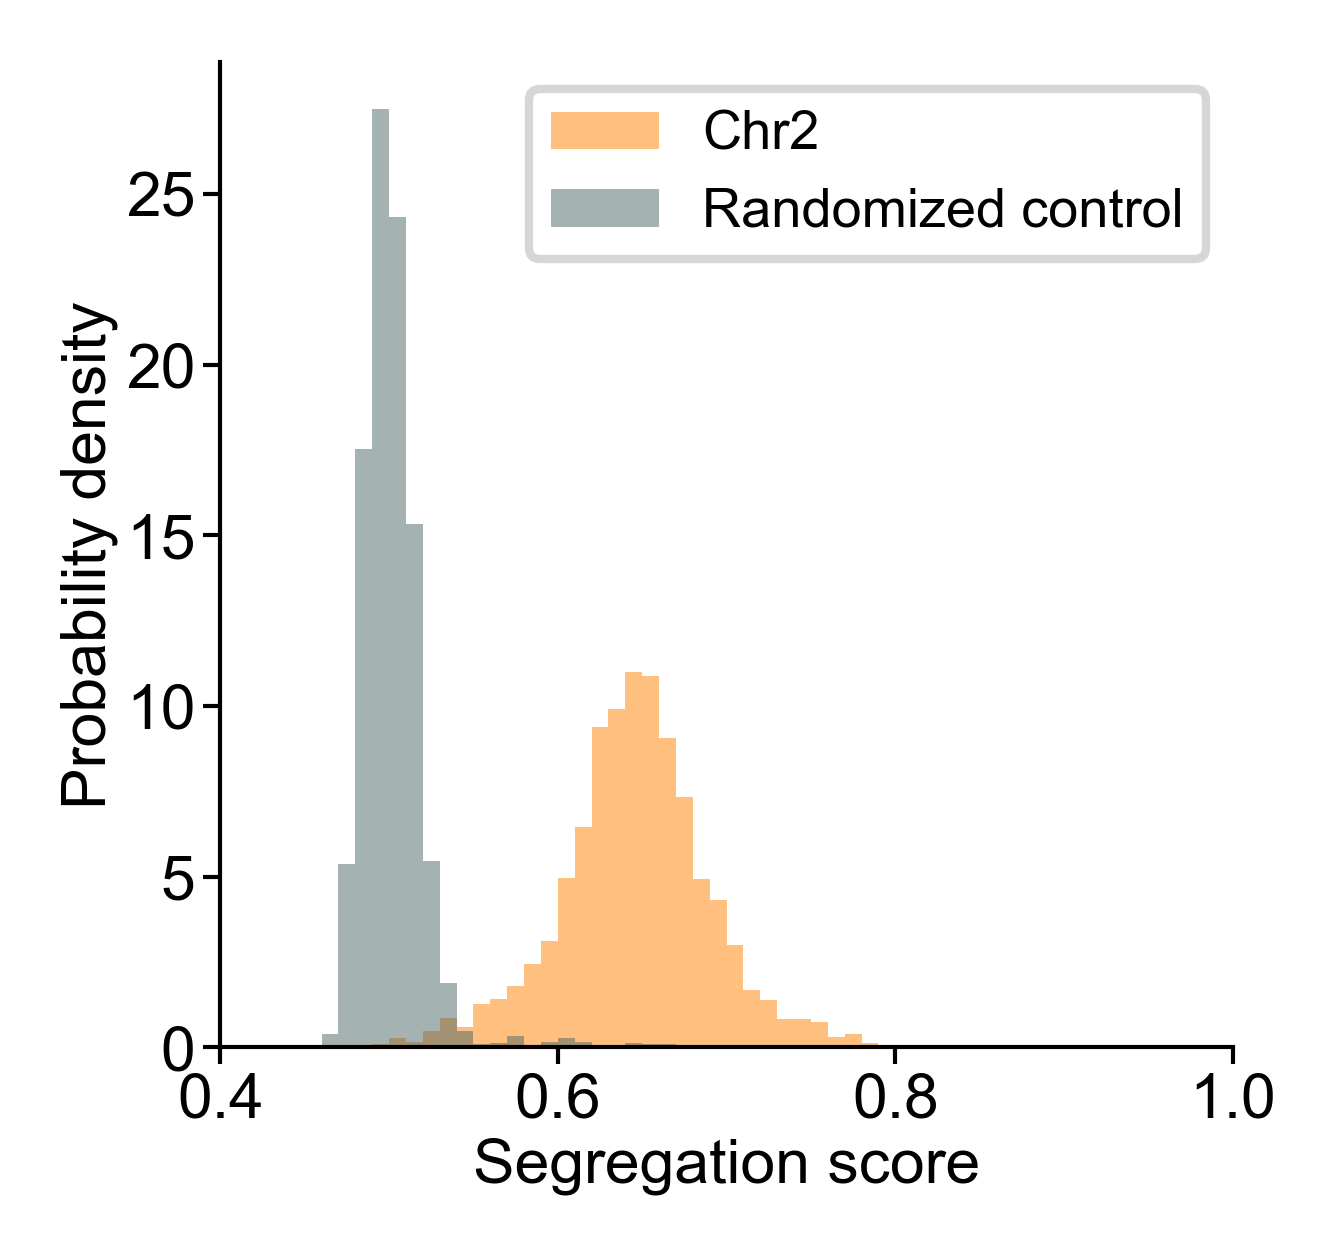

In [39]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)
ax.hist(data_rep1['segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[1,0.5,0], label='Chr2')
ax.hist(data_rep1['randomized_segregation_scores'], 100, range=(0.,1), 
        density=True, alpha=0.5, 
        color=[0.3,0.4,0.4], label='Randomized control')

ax.legend(fontsize=_font_size-1, loc='upper right')

ax.set_xlabel("Segregation score", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True) # remove bottom ticklabels for a_ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0.4,1])

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, 'Fig2F_chr2_segregation_hist_rep1.pdf'), transparent=True)
plt.show()

<a id='4'></a>
# 4. Domain-domain interaction Analysis and relationship with A/B compartments


<a id='4.1'></a>
## 4.1 call domains for chr2

In [85]:
import source.domain_tools.DomainAnalysis as da
import multiprocessing as mp

num_threads=32
domain_corr_cutoff = 0.85 
domain_dist_cutoff = 1000 # nm

_domain_args = [(_zxys, 4, 1000, domain_corr_cutoff, domain_dist_cutoff) 
                     for _zxys in data_rep1['dna_zxys']]
_domain_time = time.time()

print(f"Multiprocessing call domain starts", end=' ')
if 'domain_starts' not in data_rep1:
    with mp.Pool(num_threads) as domain_pool:
        domain_results = domain_pool.starmap(da.get_dom_starts_cor, _domain_args)
        domain_pool.close()
        domain_pool.join()
        domain_pool.terminate()
    # save
    data_rep1['domain_starts'] = [np.array(_r[-1]) for _r in domain_results]
    data_rep1['params']['domain_corr_cutoff'] = domain_corr_cutoff
    data_rep1['params']['domain_dist_cutoff'] = domain_dist_cutoff
    
print(f"in {time.time()-_domain_time:.3f}s.")

Multiprocessing call domain starts in 0.002s.


<a id='4.2'></a>
## 4.2 single-cell domains A,B composition

(Fig3C)

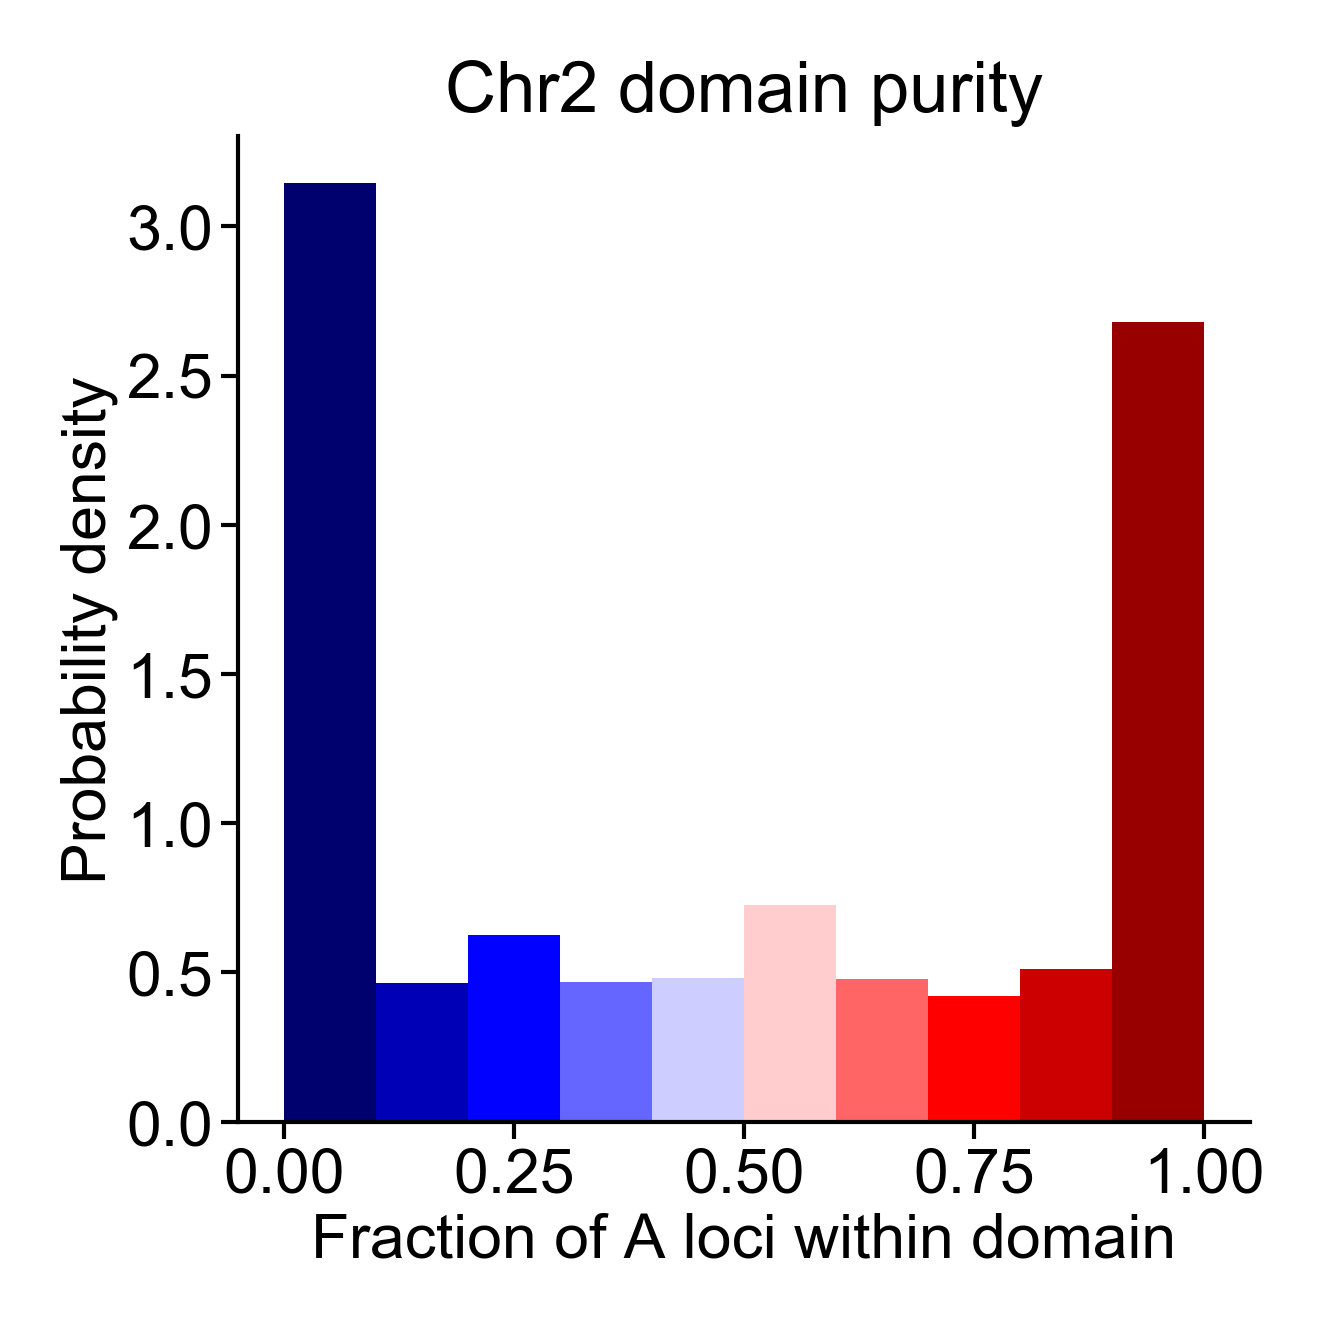

In [86]:
## purity histogram and normalized ones
_purity_bins = np.linspace(0,1,11)
_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2

AB_identities_rep1 = np.ones(len(data_rep1['dna_zxys'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

# calculate purity for p-arm
purity_rep1_list = []

for _dms in data_rep1['domain_starts']:
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    purity_rep1_list.append(np.array(_purities))
    
cmap = matplotlib.cm.seismic
bin_colors = cmap(_purity_bin_centers)
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width),dpi=600)

hist_alpha = 1

n, hbins, hpatches = ax.hist(np.concatenate(purity_rep1_list), bins=_purity_bins, 
                             alpha=hist_alpha, density=True, label='total')

for _color, _p in zip(bin_colors, hpatches):
    plt.setp(_p, 'facecolor', _color)

#hab = ax.hist(ama_AB, 24, range=(0,0.6), color='grey', alpha=hist_alpha, density=True, label='AB')
#hbb = ax.hist(ama_BB, 24, range=(0,0.6), color='b', alpha=hist_alpha, density=True, label='BB')

ax.set_xlabel("Fraction of A loci within domain", fontsize=_font_size, labelpad=1)
ax.set_ylabel("Probability density", fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.legend(fontsize=_font_size, framealpha=1, loc='upper right')
ax.set_title(f"Chr2 domain purity", pad=3, fontsize=_font_size+1)
    
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)
# save
plt.savefig(os.path.join(figure_folder, 'Fig3C_histogram_purity_rep1.pdf'), transparent=True)
plt.show()

<a id='4.3'></a>
## 4.3 call domain-domain interactions

In [87]:
import multiprocessing as mp
num_threads=32
# cutoff for:
#  domain pairs touching each other -> insulation score <= 2
#  domain pairs fully intermix with each other -> insulation score <= 1
domain_interact_cutoff = 2
domain_intermix_cutoff = 1

cutoffs = [domain_intermix_cutoff,domain_interact_cutoff]

rep1_interdomain_list = []

for _cutoff in cutoffs:
    _dom_contact_args = [(_zxys, _domain_starts, _cutoff) 
                    for _zxys, _domain_starts in zip(data_rep1['dna_zxys'],data_rep1['domain_starts'])]
    _domain_time = time.time()

    print(f"Multiprocessing call domain contacts, cutoff={_cutoff}", end=' ')
    with mp.Pool(num_threads) as dom_contact_pool:
        dom_contact_results = dom_contact_pool.starmap(ia.domain_tools.interaction.call_domain_contact, _dom_contact_args)
        dom_contact_pool.close()
        dom_contact_pool.join()
        dom_contact_pool.terminate()
    rep1_interdomain_list.append(dom_contact_results)
    
    print(f"in {time.time()-_domain_time:.3f}s.")
    

Multiprocessing call domain contacts in 70.770s.
Multiprocessing call domain contacts in 72.191s.


In [88]:
AB_identities_rep1 = np.ones(len(data_rep1['dna_zxys'][0])) * np.nan
AB_identities_rep1[data_rep1['AB_dict']['A']] = 1
AB_identities_rep1[data_rep1['AB_dict']['B']] = 0

genomic_dist_mat = squareform(pdist(data_rep1['mid_position_Mb'][:,np.newaxis]))

from tqdm import tqdm_notebook as tqdm
# calculate purity and gdists between each pairs
rep1_purity_cutoff_list = []
rep1_gdist_cutoff_list = []

for _cutoff, _interdomain_list in zip(cutoffs, rep1_interdomain_list):
    print(f"insulation threshold: {_cutoff}")
    pair_purities = []
    pair_gdists = []
    
    for _chrom_id, (_dms, _pairs) in tqdm(enumerate(zip(data_rep1['domain_starts'], _interdomain_list))):
        _dm_starts = _dms[:-1]
        _dm_ends = _dms[1:]
        _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
        # pairs called in interdomain
        for _p in _pairs:
            if _p[0] > _p[1]:
                _dm_gdist = genomic_dist_mat[int((_dm_starts[_p[0]]+_dm_ends[_p[0]])/2),
                                             int((_dm_starts[_p[1]]+_dm_ends[_p[1]])/2)]
                _dm_purites = np.array([_purities[_p[0]], _purities[_p[1]]])

                # append
                pair_purities.append(_dm_purites)
                pair_gdists.append(_dm_gdist)
                
    rep1_purity_cutoff_list.append(np.array(pair_purities))
    rep1_gdist_cutoff_list.append(np.array(pair_gdists))

    
# calculate purity and gdists between all domain candidate pairs, as the denominator
rep1_all_purity_pairs = []
rep1_all_gdists = []

for _chrom_id, _dms in tqdm(enumerate(data_rep1['domain_starts'])):
    _dm_starts = _dms[:-1]
    _dm_ends = _dms[1:]
    _purities = [np.mean(AB_identities_rep1[_s:_e]) for _s, _e in zip(_dm_starts, _dm_ends)]
    for _i, (_si, _ei) in enumerate(zip(_dm_starts, _dm_ends)):
        for _j, (_sj, _ej) in enumerate(zip(_dm_starts[:_i], _dm_ends[:_i])):
            _dm_gdist = genomic_dist_mat[int((_si+_ei)/2),
                                         int((_sj+_ej)/2)]
            _dm_purites = np.array([_purities[_i], _purities[_j]])
            # append
            rep1_all_purity_pairs.append(_dm_purites)
            rep1_all_gdists.append(_dm_gdist)
            
rep1_all_purity_pairs = np.array(rep1_all_purity_pairs)
rep1_all_gdists = np.array(rep1_all_gdists)

insulation threshold: 1



insulation threshold: 2


<a id='4.4'></a>
## 4.4 domain interaction freqeuncy given purity

(Fig3E)

In [89]:
## purity histogram and normalized ones
# choose one among the following
#_purity_bins = np.array([-1e-5,  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1+1e-5])
#_purity_bins = np.array([-1e-5, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 1+1e-5])
#_purity_bins = np.array([-1e-5, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1+1e-5])
_purity_bins = np.array([-1e-5, 1/6, 2/6, 3/6, 4/6, 5/6, 1+1e-5])
#_purity_bins = np.array([-1e-5, 0.2, 0.4, 0.6, 0.8, 1+1e-5])

_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2


rep1_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                    len(_purity_bin_centers)])
# get cutoff=2 case
_purity_list = rep1_purity_cutoff_list[-1]
_gdist_list = rep1_gdist_cutoff_list[-1]
for _pair, _gd in tqdm(zip(_purity_list, _gdist_list)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p < _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q < _purity_bins[1:]))[0][0]
    # append
    rep1_purity_count_mat[_p_ind,_q_ind] += 1
    rep1_purity_count_mat[_q_ind,_p_ind] += 1
    
rep1_all_purity_count_mat = np.zeros([len(_purity_bin_centers),
                                        len(_purity_bin_centers)])
for _pair, _gd in tqdm(zip(rep1_all_purity_pairs, rep1_all_gdists)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p < _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q < _purity_bins[1:]))[0][0]
    # append
    rep1_all_purity_count_mat[_p_ind,_q_ind] += 1
    rep1_all_purity_count_mat[_q_ind,_p_ind] += 1

# calculate this probability matrix
rep1_purity_prob_mat = rep1_purity_count_mat / rep1_all_purity_count_mat

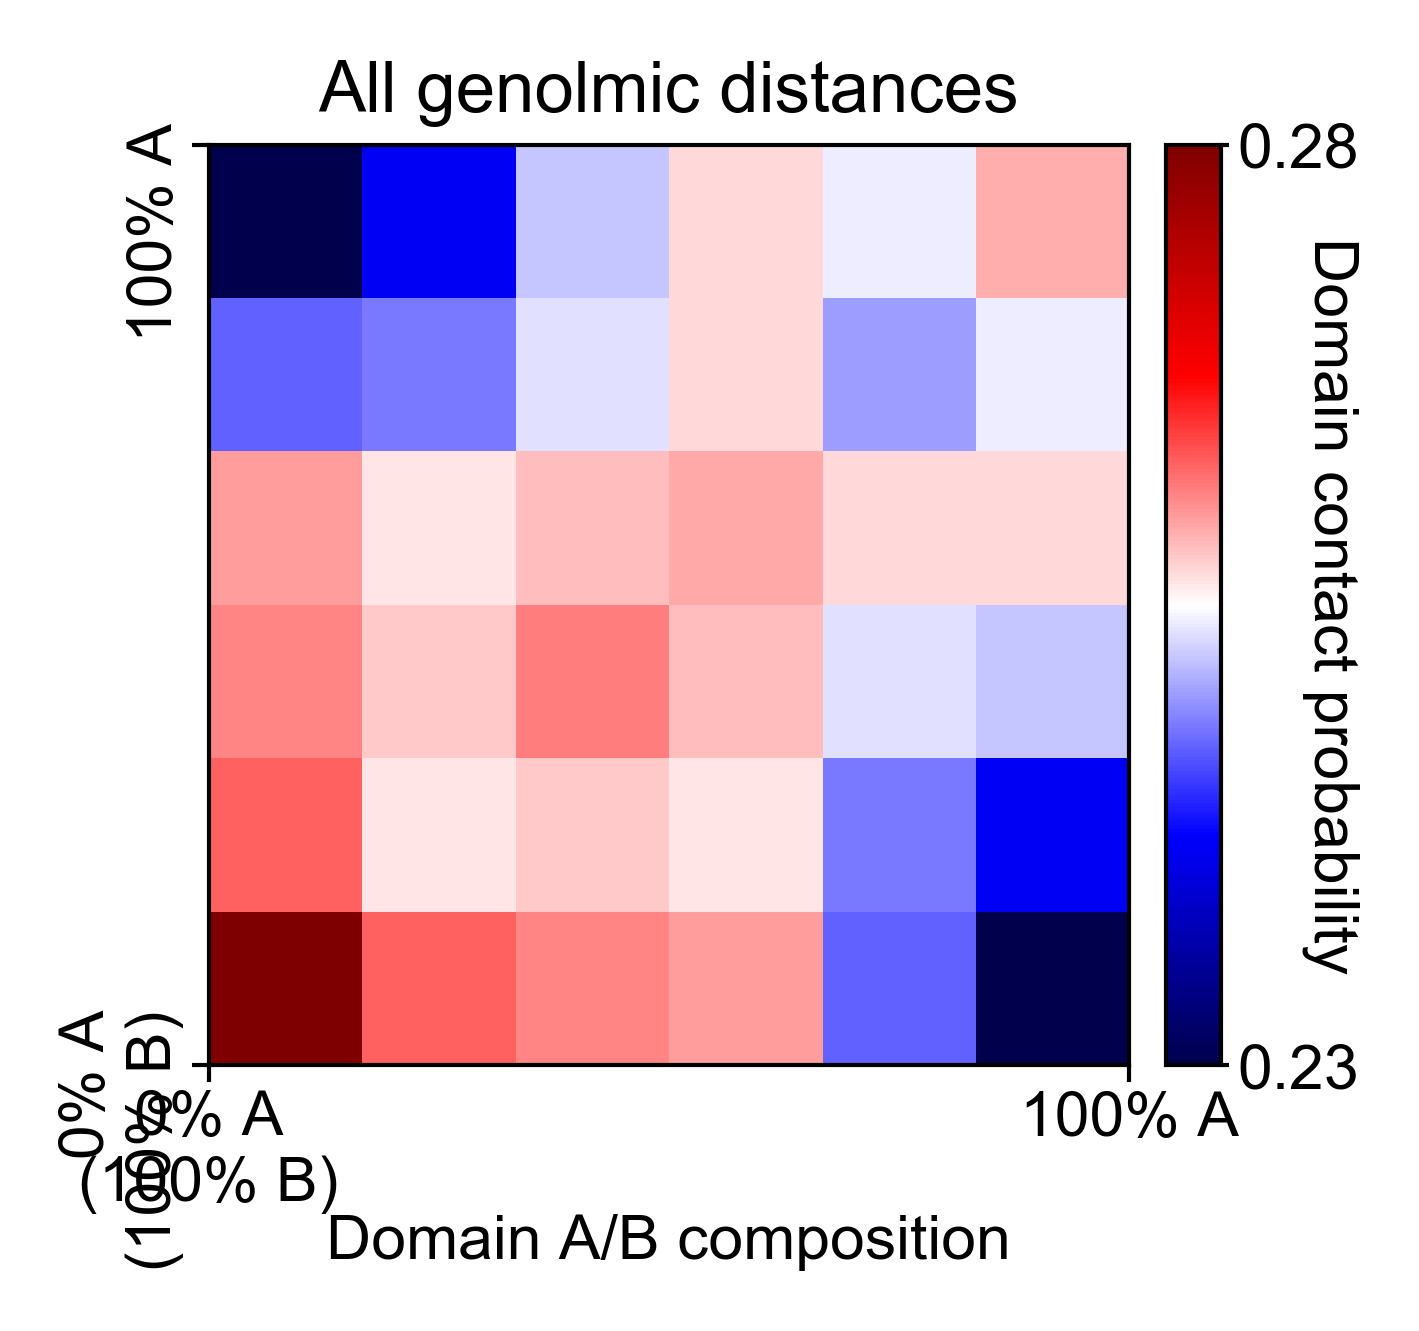

In [94]:
color_limits = [0.23, 0.28]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

_pf = ax.imshow(rep1_purity_prob_mat, cmap='seismic', interpolation='nearest',
                vmin=min(color_limits), vmax=max(color_limits))

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_title(f"Chr2 rep1", 
             fontsize=_font_size, pad=2)

# limits
_xlims = [-0.5, len(_purity_bins)-1.5]
ax.set_ylim(_xlims)
ax.set_xlim(_xlims)
# ticks
_xticks = [-0.5, len(_purity_bins)-1.5]
_xtick_labels = ["0% A\n(100% B)", '100% A']
ax.set_xticks(_xticks)
ax.set_xticklabels(_xtick_labels)
ax.set_yticks(_xticks)
ax.set_yticklabels(_xtick_labels, rotation=90)

ax.set_xlabel('Domain A/B composition', labelpad=0, fontsize=_font_size)

# locate ax
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, ticks=color_limits)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Domain contact probability', fontsize=_font_size, 
               labelpad=0, rotation=270)

ax.set_title(f"All genolmic distances", pad=4, fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3E_chr2_contact_prob_given_purity_rep1_bins-{len(_purity_bins)-1}.pdf'), 
            transparent=True)

plt.show()

<a id='4.5'></a>
## 4.5 domain interaction freqeuncy given purity and long genomic distances

(Fig3G)

In [96]:
gd_cutoff = 80 # Mb

## purity histogram and normalized ones ( should be same as 3E)
#_purity_bins = np.linspace(0,1,11)
#_purity_bin_centers = (_purity_bins[1:] + _purity_bins[:-1])/2

rep1_purity_high_gd_count_mat = np.zeros([len(_purity_bin_centers),
                                    len(_purity_bin_centers)])
# get cutoff=2 case
_purity_list = rep1_purity_cutoff_list[-1]
_gdist_list = rep1_gdist_cutoff_list[-1]
for _pair, _gd in tqdm(zip(_purity_list, _gdist_list)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p < _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q < _purity_bins[1:]))[0][0]
    if _gd > gd_cutoff:
        rep1_purity_high_gd_count_mat[_p_ind,_q_ind] += 1
        rep1_purity_high_gd_count_mat[_q_ind,_p_ind] += 1
    
rep1_all_purity_high_gd_count_mat = np.zeros([len(_purity_bin_centers),
                                        len(_purity_bin_centers)])
for _pair, _gd in tqdm(zip(rep1_all_purity_pairs, rep1_all_gdists)):
    _p, _q = _pair
    _p_ind = np.where((_p >= _purity_bins[:-1]) & (_p < _purity_bins[1:]))[0][0]
    _q_ind = np.where((_q >= _purity_bins[:-1]) & (_q < _purity_bins[1:]))[0][0]
    
    if _gd > gd_cutoff:
        rep1_all_purity_high_gd_count_mat[_p_ind,_q_ind] += 1
        rep1_all_purity_high_gd_count_mat[_q_ind,_p_ind] += 1

# calculate this probability matrix
rep1_purity_high_gd_prob_mat = rep1_purity_high_gd_count_mat / rep1_all_purity_high_gd_count_mat

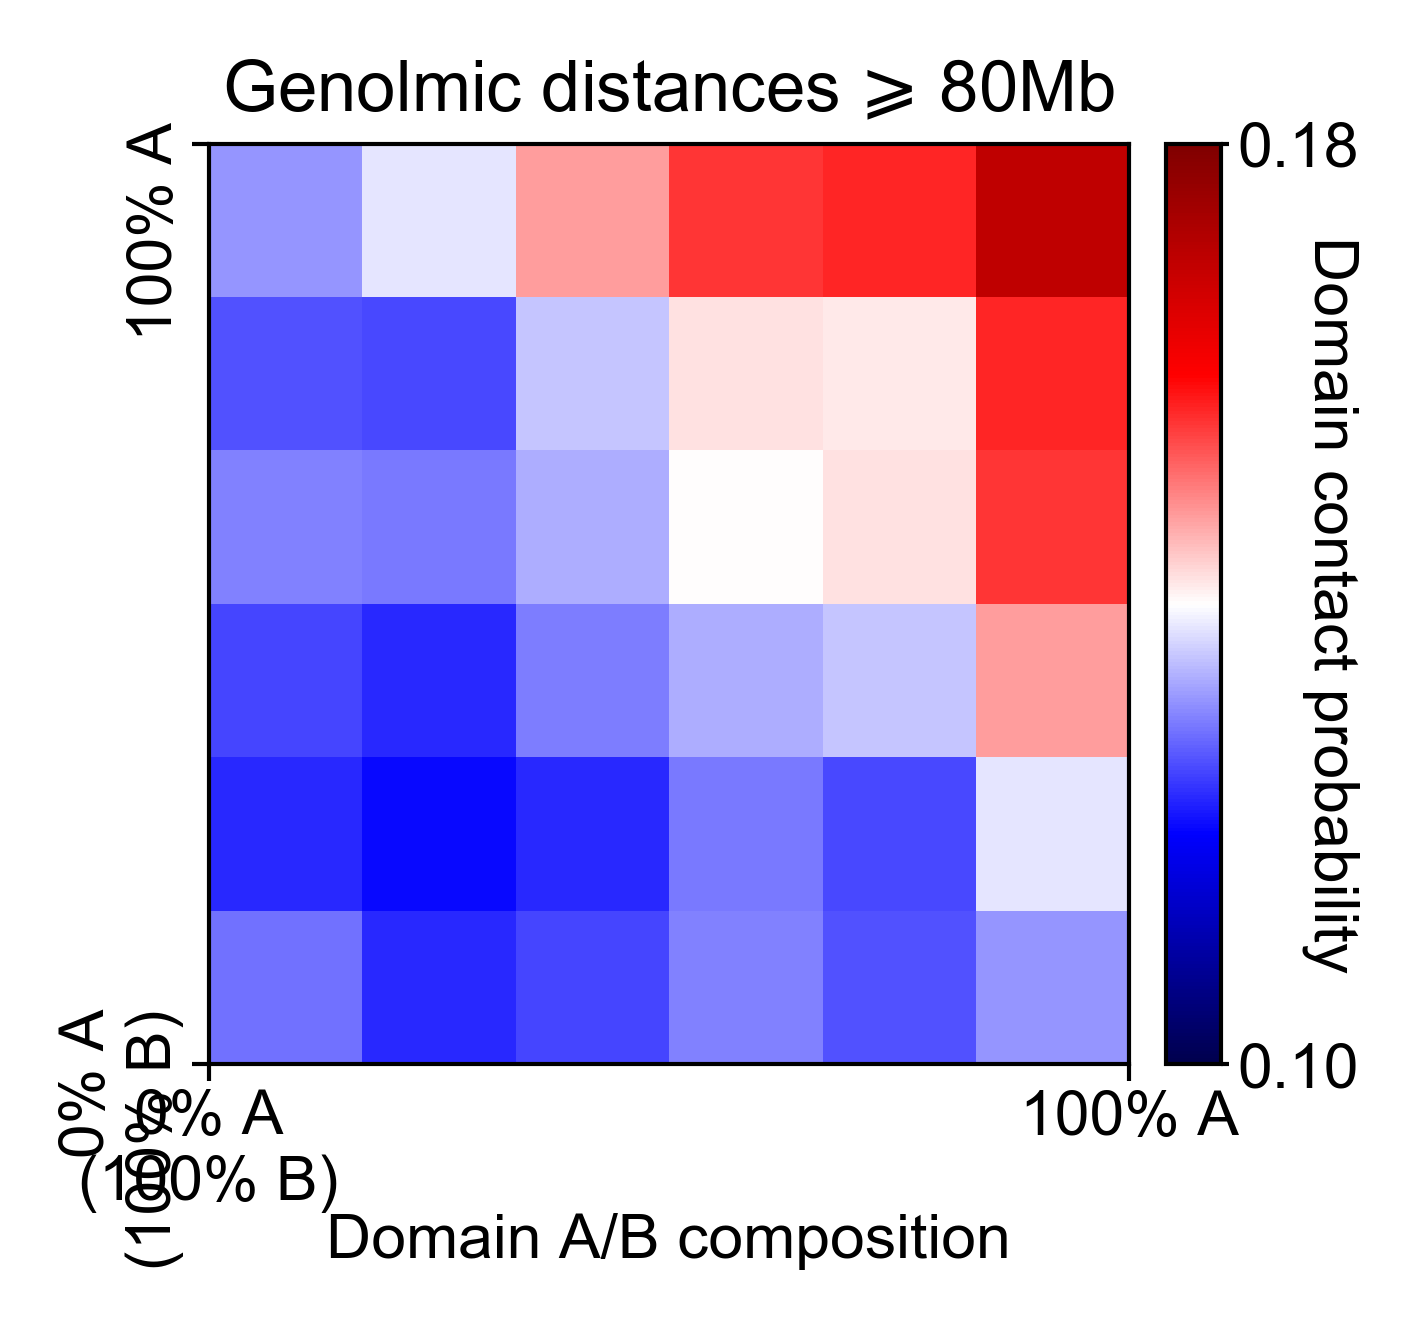

In [108]:
color_limits = [0.1, 0.18]

fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

_pf = ax.imshow(rep1_purity_high_gd_prob_mat, cmap='seismic', interpolation='nearest',
                vmin=min(color_limits), vmax=max(color_limits))

ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelbottom=True, labelleft=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

ax.set_title(f"Chr2 rep1", 
             fontsize=_font_size, pad=2)

# limits
_xlims = [-0.5, len(_purity_bins)-1.5]
ax.set_ylim(_xlims)
ax.set_xlim(_xlims)
# ticks
_xticks = [-0.5, len(_purity_bins)-1.5]
_xtick_labels = ["0% A\n(100% B)", '100% A']
ax.set_xticks(_xticks)
ax.set_xticklabels(_xtick_labels)
ax.set_yticks(_xticks)
ax.set_yticklabels(_xtick_labels, rotation=90)

ax.set_xlabel('Domain A/B composition', labelpad=0, fontsize=_font_size)

# locate ax
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax, ticks=color_limits)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Domain contact probability', fontsize=_font_size, 
               labelpad=0, rotation=270)

ax.set_title(f'Genolmic distances $\geqslant$ {gd_cutoff}Mb', pad=4, fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1, right=0.85)

plt.savefig(os.path.join(figure_folder, f'Fig3G_chr2_contact_prob_given_purity_high_gd_rep1_bins-{len(_purity_bins)-1}.pdf'), transparent=True)

plt.show()

<a id='4.6'></a>
## 4.6 domain interaction freqeuncy given genomic distances 

between domain centers

(Fig3F)

2


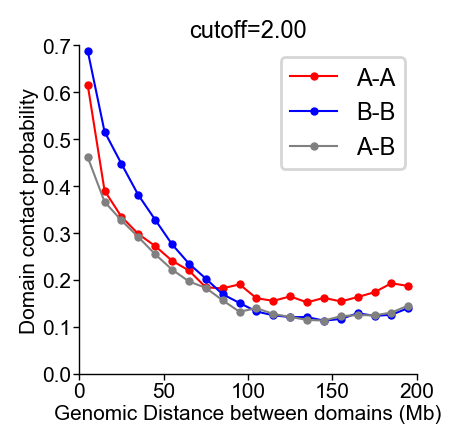

In [103]:
num_bins = 20
p_genomic_dist_mat = genomic_dist_mat[p_crop, p_crop]
_bins = np.linspace(np.min(p_genomic_dist_mat), 
                    #np.max(p_genomic_dist_mat), 
                    200,
                    num_bins+1)
_bin_centers = (_bins[:-1] + _bins[1:]) / 2
A_th = 1.0
B_th = 0.0
#A_th = 0.9
#B_th = 0.1

# Fig3F: cutoff = 2
_cutoff =  2
_index = cutoffs.index(_cutoff)
_gdists = rep1_gdist_cutoff_list[_index]
_purity_pairs = rep1_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0] <= B_th) & (_purity_pairs[:,1] <= B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0] >= A_th) & (_purity_pairs[:,1] >= A_th)],bins=_bins)
nBB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0] <= B_th) & (rep1_all_purity_pairs[:,1] <= B_th)],bins=_bins)
nAA_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0] >= A_th) & (rep1_all_purity_pairs[:,1] >= A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0] <= B_th)&(_purity_pairs[:,1] >= A_th) \
                             | (_purity_pairs[:,0] >= A_th)&(_purity_pairs[:,1] <= B_th)],bins=_bins)
nAB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0] >= A_th)&(rep1_all_purity_pairs[:,1] <= B_th) \
                                    | (rep1_all_purity_pairs[:,0] <= B_th)&(rep1_all_purity_pairs[:,1] >= A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='A-A')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='B-B')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='A-B')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.7])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3F_chr2_insulation_genomic_{_cutoff:.2f}_rep1_{A_th}_{B_th}.pdf"), transparent=True)
plt.show()

<a id='4.7'></a>
## 4.7 intermixing domain interaction freqeuncy given genomic distances 

between domain centers

insulation score smaller than 1 

(Fig3H)

1


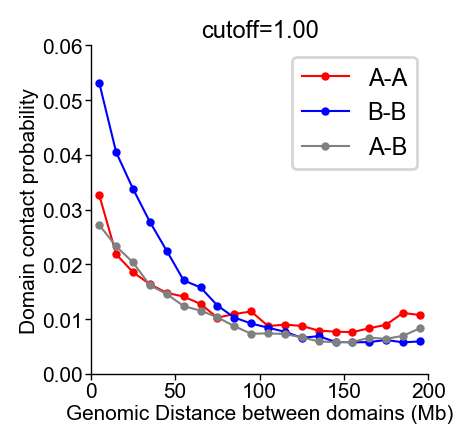

In [104]:
# Fig3H: cutoff = 1
_cutoff =  1
_index = cutoffs.index(_cutoff)
_gdists = rep1_gdist_cutoff_list[_index]
_purity_pairs = rep1_purity_cutoff_list[_index]


print(_cutoff)
nBB,_ = np.histogram(_gdists[(_purity_pairs[:,0] <= B_th) & (_purity_pairs[:,1] <= B_th)],bins=_bins)
nAA,_ = np.histogram(_gdists[(_purity_pairs[:,0] >= A_th) & (_purity_pairs[:,1] >= A_th)],bins=_bins)
nBB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0] <= B_th) & (rep1_all_purity_pairs[:,1] <= B_th)],bins=_bins)
nAA_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0] >= A_th) & (rep1_all_purity_pairs[:,1] >= A_th)],bins=_bins)
nAB,_ = np.histogram(_gdists[(_purity_pairs[:,0] <= B_th)&(_purity_pairs[:,1] >= A_th) \
                             | (_purity_pairs[:,0] >= A_th)&(_purity_pairs[:,1] <= B_th)],bins=_bins)
nAB_all,_ = np.histogram(rep1_all_gdists[(rep1_all_purity_pairs[:,0] >= A_th)&(rep1_all_purity_pairs[:,1] <= B_th) \
                                    | (rep1_all_purity_pairs[:,0] <= B_th)&(rep1_all_purity_pairs[:,1] >= A_th)],bins=_bins)

fig, ax = plt.subplots(dpi=200, figsize=(_single_col_width, _single_col_width))
_line_AA = ax.plot(_bin_centers,nAA/nAA_all,'-o', linewidth=0.75, markersize=2, color='r', label='A-A')
_line_BB = ax.plot(_bin_centers,nBB/nBB_all,'-o', linewidth=0.75, markersize=2, color='b', label='B-B')
_line_AB = ax.plot(_bin_centers,nAB/nAB_all,'-o', linewidth=0.75, markersize=2, color='grey', label='A-B')

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([0, np.max(_bins)])
ax.set_ylim([0., 0.06])

ax.set_xlabel(f"Genomic Distance between domains (Mb)", labelpad=1, fontsize=_font_size)
ax.set_ylabel(f"Domain contact probability", labelpad=1, fontsize=_font_size)
ax.set_title(f"cutoff={_cutoff:.2f}", pad=3, fontsize=_font_size+1)

ax.legend(loc='upper right',fontsize=_font_size+1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.savefig(os.path.join(figure_folder, f"Fig3H_chr2_insulation_genomic_{_cutoff:.2f}_rep1_{A_th}_{B_th}.pdf"), transparent=True)
plt.show()

<a id='5'></a>

# 5. Compare p-arm of two replicates

<a id='5.1'></a>
## 5.1 generate population-averaged maps

In [13]:
zxys_rep1_list = np.array(data_rep1['dna_zxys'])
distmap_rep1_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep1_list])
# calculate contact freq map
contact_th = 500
contact_rep1_map = np.sum(distmap_rep1_list<contact_th, axis=0) / np.sum(np.isnan(distmap_rep1_list)==False, axis=0)

zxys_rep2_list = np.array(data_rep2['dna_zxys'])
distmap_rep2_list = np.array([squareform(pdist(_zxy)) for _zxy in zxys_rep2_list])
# calculate contact freq map
contact_th = 500
contact_rep2_map = np.sum(distmap_rep2_list<contact_th, axis=0) / np.sum(np.isnan(distmap_rep2_list)==False, axis=0)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [20]:
# compare only p-arm
p_zxys_rep1_list = zxys_rep1_list[:, p_crop, :]
p_distmap_rep1_list = distmap_rep1_list[:,p_crop, p_crop]
# calculate median and contact maps
p_median_rep1_map = np.nanmedian(p_distmap_rep1_list, axis = 0)
p_contact_rep1_map = contact_rep1_map[p_crop, p_crop]

# compare only p-arm
p_zxys_rep2_list = zxys_rep2_list[:, p_crop, :]
p_distmap_rep2_list = distmap_rep2_list[:,p_crop, p_crop]
# calculate median and contact maps
p_median_rep2_map = np.nanmedian(p_distmap_rep2_list, axis = 0)
p_contact_rep2_map = contact_rep2_map[p_crop, p_crop]

<a id='5.2'></a>
## 5.2 scatter plot of median distances between two replicates

In [62]:
fail_rate_th = 0.007
# failure rates
p_rep1_failure_rates = np.mean(np.isnan(np.array(p_zxys_rep1_list)).sum(2)>0, axis=0)
p_rep2_failure_rates = np.mean(np.isnan(np.array(p_zxys_rep2_list)).sum(2)>0, axis=0)


kept_regions = np.where((p_rep1_failure_rates < fail_rate_th) \
                        & (p_rep2_failure_rates < fail_rate_th))[0]
print(len(kept_regions))

p_rep1_entries = p_median_rep1_map[kept_regions][:,kept_regions]
p_rep1_entries = p_rep1_entries[np.triu_indices(len(p_rep1_entries),1)]
p_rep2_entries = p_median_rep2_map[kept_regions][:,kept_regions]
p_rep2_entries = p_rep2_entries[np.triu_indices(len(p_rep2_entries),1)]

from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False).fit(p_rep1_entries[:, np.newaxis], p_rep2_entries)

slope = model.coef_[0]
print(slope)
pearsonr2 = model.score(p_rep1_entries[:, np.newaxis], p_rep2_entries)
print(np.sqrt(pearsonr2))

354
1.0210875930061056
0.9686607209272622


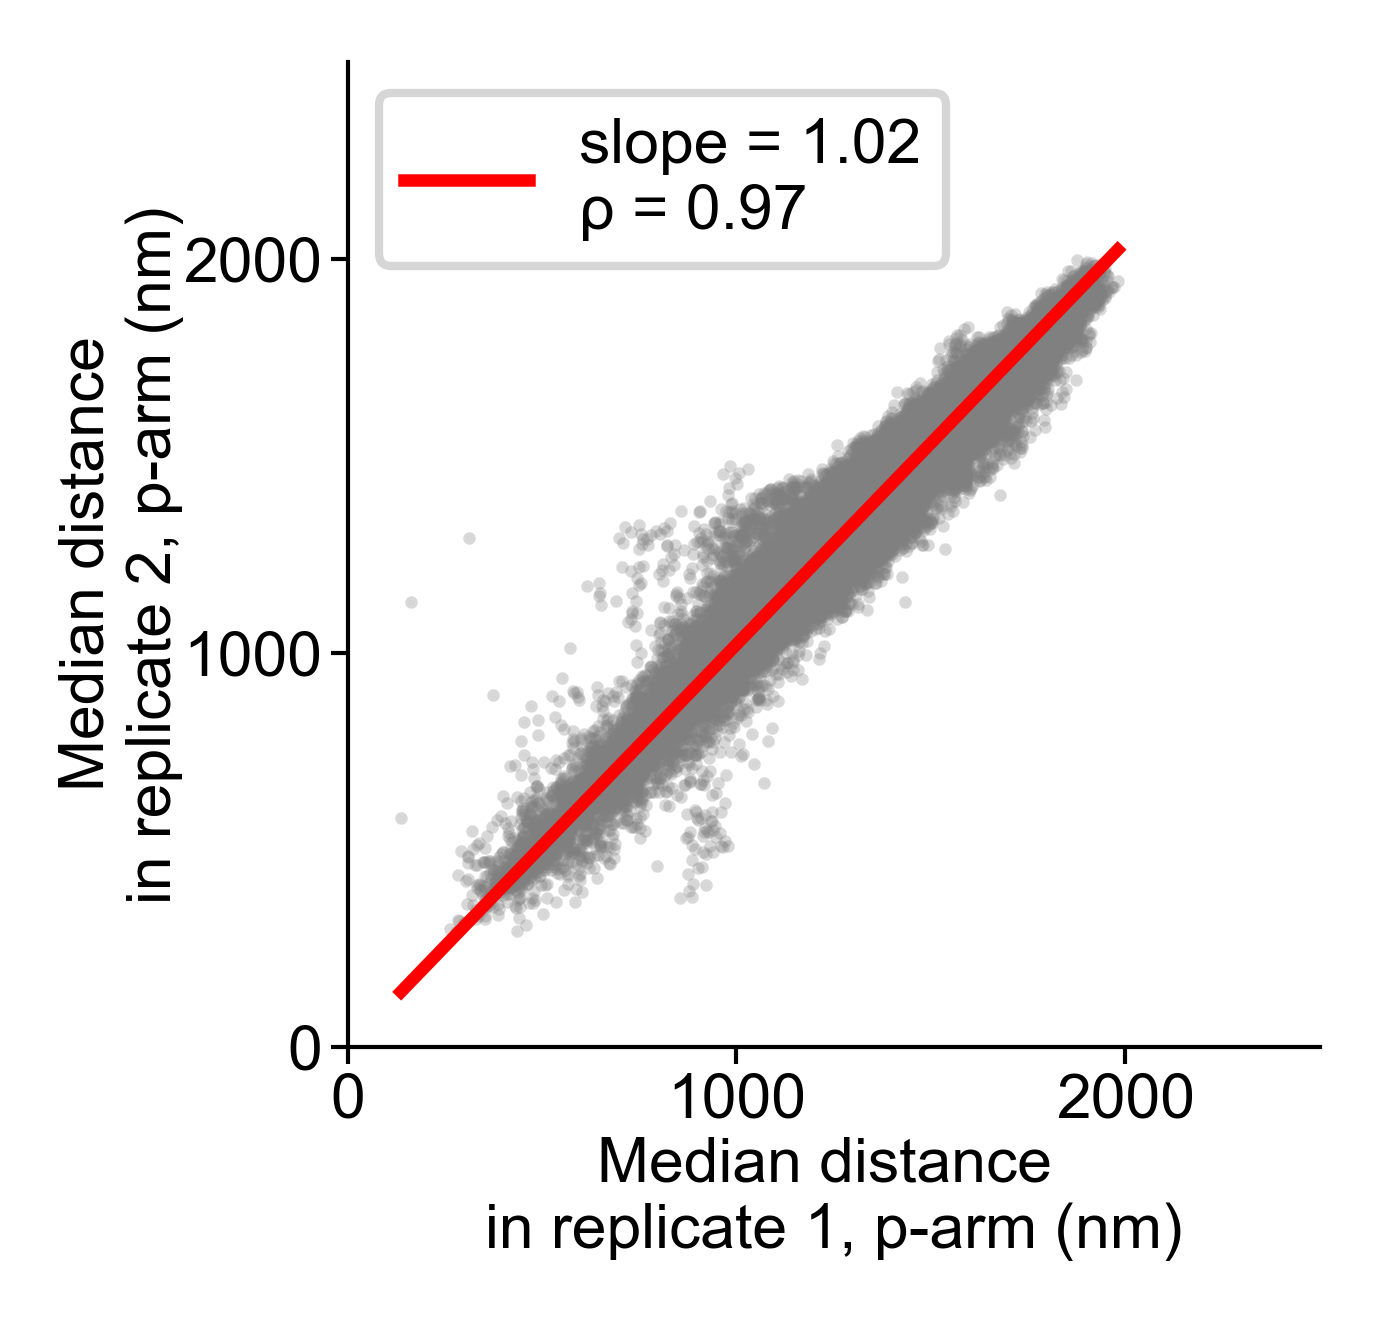

In [63]:
# plot scatter for two replicates
xlim = [0,2500]
# draw scatter plot
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=_dpi)

ax.set_xlabel('Median distance \nin replicate 1, p-arm (nm)', 
              labelpad=1, fontsize=_font_size)
ax.set_ylabel('Median distance \nin replicate 2, p-arm (nm)', 
              labelpad=0, fontsize=_font_size)
ax.set_xlim(xlim)
xticks = np.arange(min(xlim), max(xlim)+1, 1000)
ax.set_xticks(xticks, minor=False)
ax.set_ylim(xlim)
ax.set_yticks(xticks, minor=False)

ax.tick_params('both', labelsize=_font_size, 
        width=_ticklabel_width, length=_ticklabel_size,
        pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.gcf().subplots_adjust(bottom=0.15, left=0.18)

# generate fitted line
reg_x = np.linspace(min(p_rep1_entries),max(p_rep1_entries),10)
reg_y = slope * reg_x 

# plot frame only
plt.savefig(os.path.join(figure_folder, 'chr2_scatter_median_replicate.pdf'), transparent=True)

# plot
ax.plot(p_rep1_entries, p_rep2_entries, '.', color='gray', 
        alpha=0.3, markersize=1, )
ax.plot(reg_x, reg_y, 'r', label=f'slope = {slope:.2f}\n\u03C1 = {np.sqrt(pearsonr2):.2f}')

plt.legend(loc='upper left', fontsize=_font_size)

# save png for illustrator
plt.savefig(os.path.join(figure_folder, 'chr2_scatter_median_replicate.png'),
            transparent=False)

plt.show()

<a id='5.3'></a>
## 5.3 p-arm AB calling for replicate 2

In [65]:
# Do PCA
from sklearn.decomposition import PCA
# parameters used for PCA compartment calling
contact_gaussian_sigma = 0.5
hic_gaussian_sigma = 0.5

LinregressResult(slope=-0.550104434228682, intercept=-1.3670176214024068, rvalue=-0.8532385862421097, pvalue=0.0, stderr=0.0013338561448316094)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


LinregressResult(slope=-0.7228033386786183, intercept=3.3748169744754692, rvalue=-0.7250408584341537, pvalue=0.0, stderr=0.0030186725566035987)


E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log


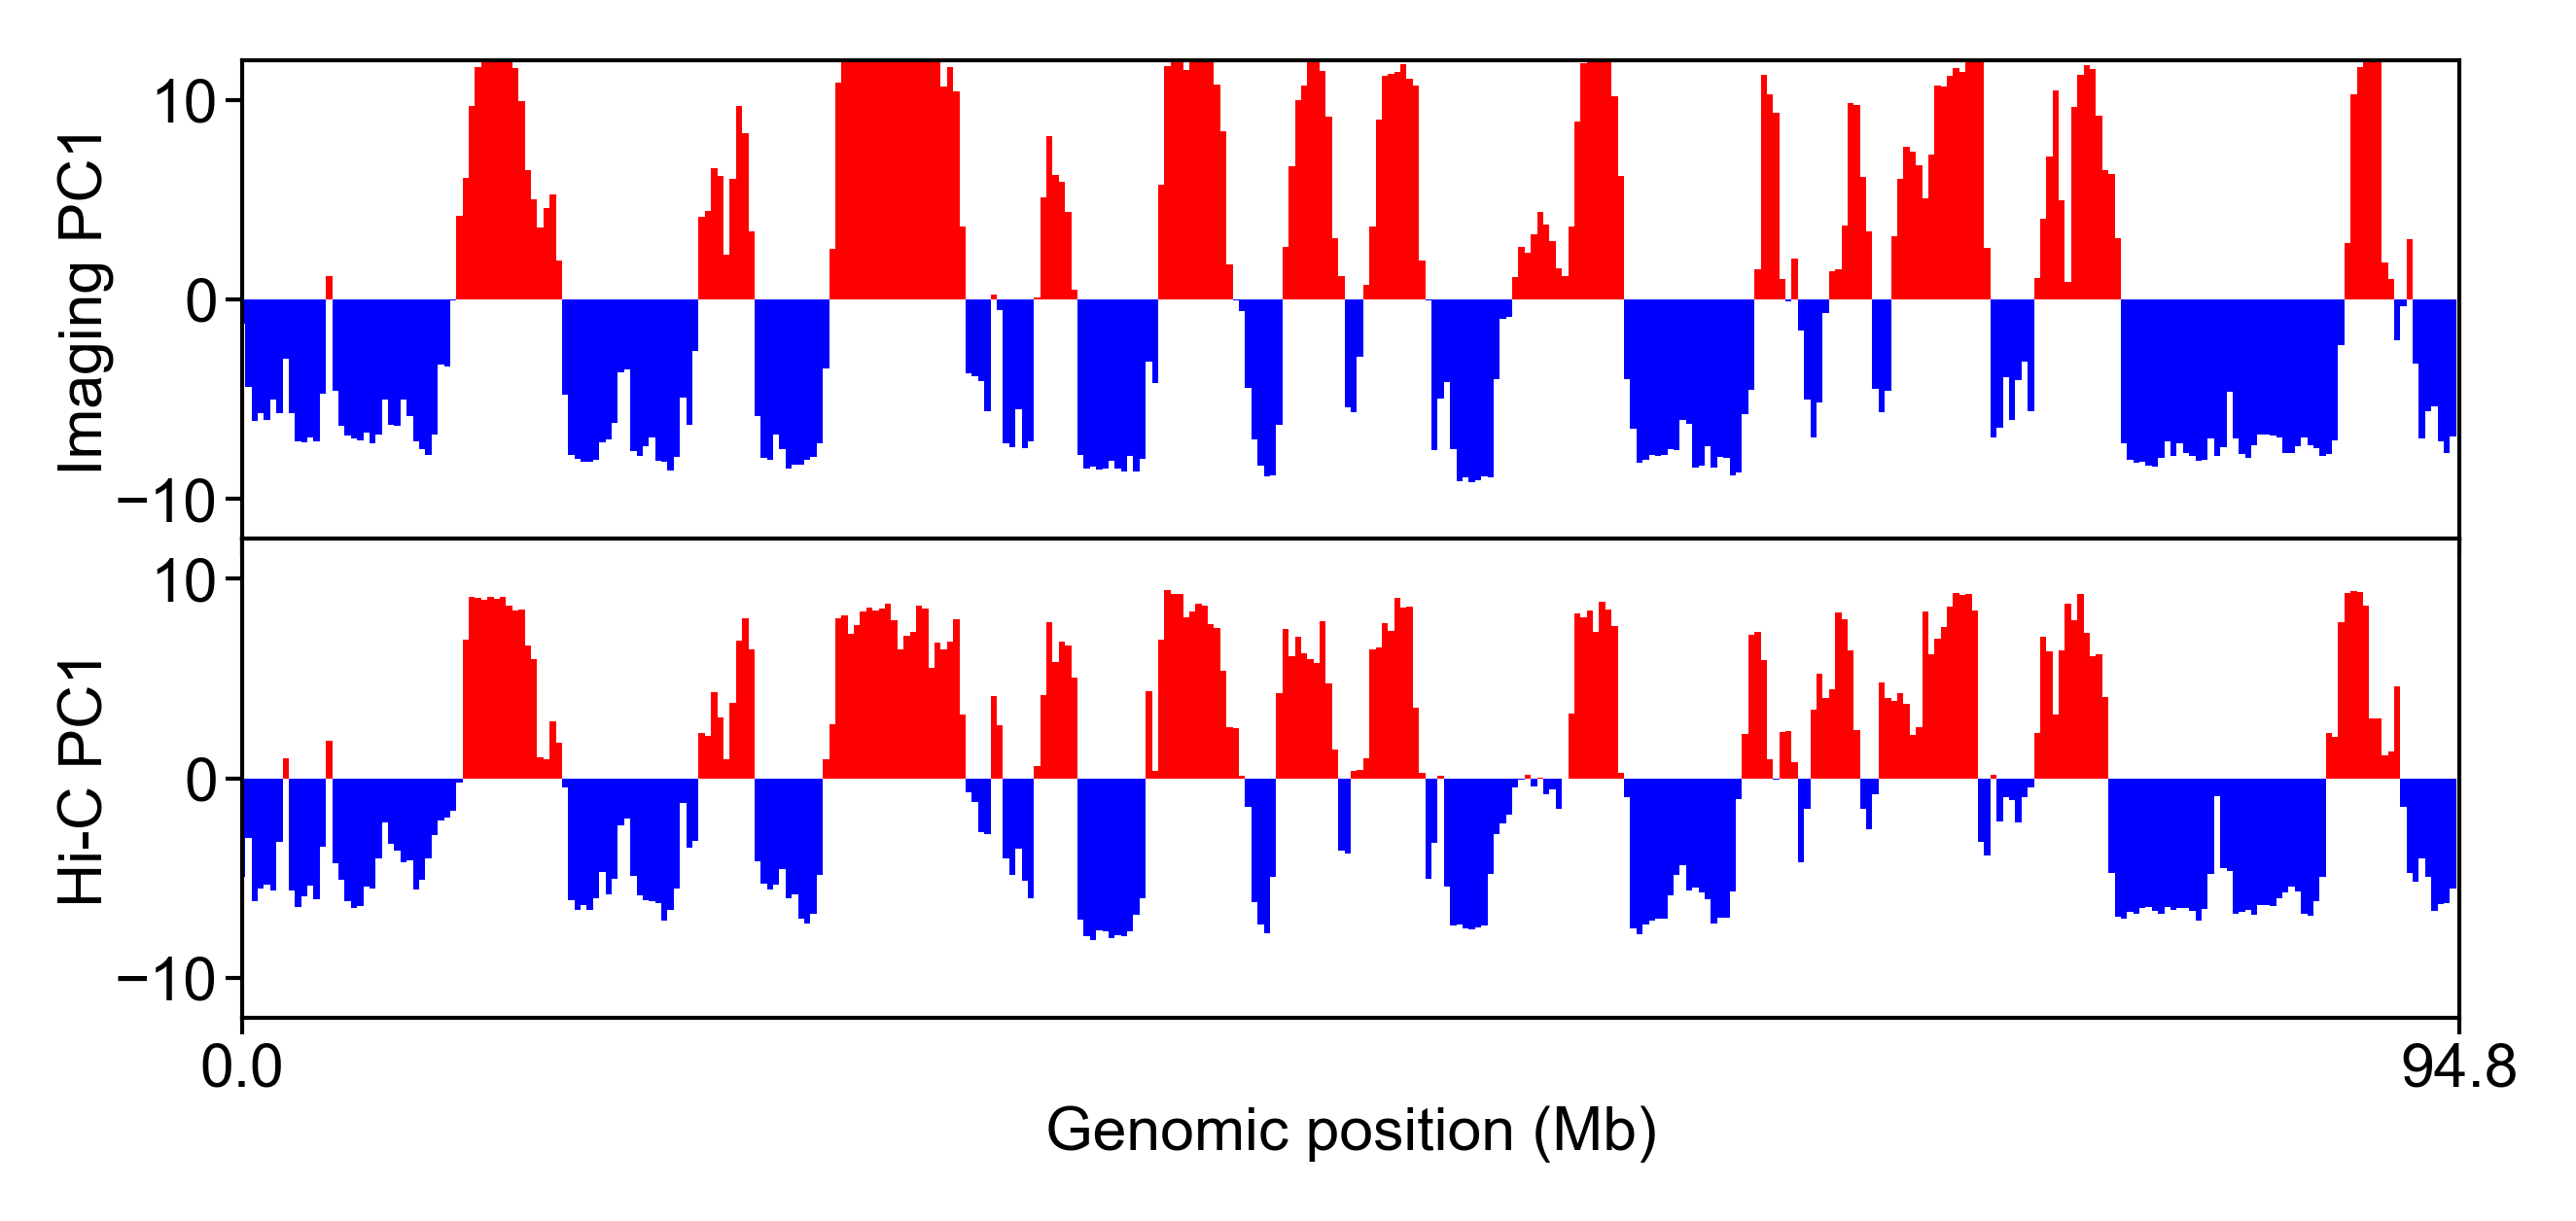

In [68]:
# normalize genomic distance effects
genomic_distance_map = squareform(pdist(data_rep2['mid_position_Mb'][:,np.newaxis]))
genomic_distance_entries = genomic_distance_map[np.triu_indices(len(genomic_distance_map),1)]

## p arm, proximity
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_contact_rep2_map = contact_rep2_map[p_crop, p_crop]
# normalize genomic distance effect
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
contact_entries = p_contact_rep2_map[np.triu_indices(len(p_contact_rep2_map),1)]
p_contact_kept = (genomic_distance_entries > 0) * (contact_entries > 0)
p_contact_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_contact_kept]), 
                                      np.log(contact_entries[p_contact_kept]))
print(p_contact_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_contact_lr.slope + p_contact_lr.intercept)
for _i in range(len(p_normalization_mat)):
    p_normalization_mat[_i,_i] = 1
p_normed_contact_rep2_map = p_contact_rep2_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_contact_corr_rep2_map = np.corrcoef(gaussian_filter(p_normed_contact_rep2_map, contact_gaussian_sigma))
# PCA
p_contact_model_rep2 = PCA(1)
p_contact_model_rep2.fit(p_contact_corr_rep2_map)
p_contact_pc1_rep2 = np.reshape(p_contact_model_rep2.fit_transform(p_contact_corr_rep2_map), -1)

## p arm, Hi-C
p_gd_map = genomic_distance_map[p_crop, p_crop]
p_hic_map = hic_map[p_crop, p_crop]
# normalize genomic distance effects
genomic_distance_entries = p_gd_map[np.triu_indices(len(p_gd_map),1)]
hic_entries = p_hic_map[np.triu_indices(len(p_hic_map),1)]
p_hic_kept = (genomic_distance_entries > 0) * (hic_entries > 0)
p_hic_lr = scipy.stats.linregress(np.log(genomic_distance_entries[p_hic_kept]), 
                              np.log(hic_entries[p_hic_kept]))
print(p_hic_lr)
p_normalization_mat = np.exp(np.log(p_gd_map) * p_hic_lr.slope + p_hic_lr.intercept)
#for _i in range(len(p_normalization_mat)):
#    p_normalization_mat[_i,_i] = 1
p_normed_hic_map = p_hic_map / p_normalization_mat
# apply gaussian
from scipy.ndimage import gaussian_filter

p_hic_corr_map = np.corrcoef(gaussian_filter(p_normed_hic_map, hic_gaussian_sigma))
# PCA
p_hic_model = PCA(1)
p_hic_model.fit(p_hic_corr_map)
p_hic_pc1 = np.reshape(p_hic_model.fit_transform(p_hic_corr_map), -1)


# Plot vs. Hi-C
## pc1 barplot
fig, ax = plt.subplots(figsize=(_double_col_width, _single_col_width), dpi=600)
grid = plt.GridSpec(2, 1, height_ratios=[1,1], hspace=0., wspace=0.)
contact_ax = plt.subplot(grid[0])
contact_ax.bar(np.where(p_contact_pc1_rep2>=0)[0],
               p_contact_pc1_rep2[p_contact_pc1_rep2>=0],
               width=1, color='r', label='A')
contact_ax.bar(np.where(p_contact_pc1_rep2<0)[0],
               p_contact_pc1_rep2[p_contact_pc1_rep2<0],
               width=1, color='b', label='B')
contact_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in contact_ax.spines.items()]
contact_ax.set_ylim([-12,12])
contact_ax.set_yticks([-10,0,10])
contact_ax.set_ylabel("Imaging PC1", fontsize=_font_size, labelpad=0)

# hic-ax
hic_ax = plt.subplot(grid[1], sharex=contact_ax)

hic_ax.bar(np.where(p_hic_pc1>=0)[0],
               p_hic_pc1[p_hic_pc1>=0],
               width=1, color='r', label='A')
hic_ax.bar(np.where(p_hic_pc1<0)[0],
               p_hic_pc1[p_hic_pc1<0],
               width=1, color='b', label='B')
hic_ax.tick_params('both', labelsize=_font_size, 
            width=_ticklabel_width, length=_ticklabel_size,
            pad=1,) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in hic_ax.spines.items()]
hic_ax.set_ylim([-12,12])
hic_ax.set_yticks([-10,0,10])
hic_ax.set_ylabel("Hi-C PC1", fontsize=_font_size, labelpad=0)

# set x
hic_ax.set_xlim([0, len(p_contact_pc1_rep2)])
_xticks = [0, len(p_contact_pc1_rep2)]
_xticklabels =  [data_rep2['start_position_Mb'][p_crop.start],
                 data_rep2['end_position_Mb'][p_crop.stop-1],] 

hic_ax.set_xticks(_xticks)
hic_ax.set_xticklabels(_xticklabels)

hic_ax.set_xlabel(f'Genomic position (Mb)', fontsize=_font_size, labelpad=1)

plt.gcf().subplots_adjust(bottom=0.15, left=0.1)

plt.savefig(os.path.join(figure_folder, f'chr2_p_arm_PC1_barplot_rep2.png'), transparent=True)

plt.show()